--- Comparing Patient IDs Across Datasets ---
Total patients in Radiomic Features file: 65
Total patients in Clinical Data file (kaggle_3m): 110
-------------------------
Number of patients in BOTH files: 61
Patients unique to Radiomic Features: 4
Patients unique to Clinical Data:   49
--- End of Comparison Report ---

Found 61 patients common to both datasets.
Processing patient 1/61: TCGA_CS_4942


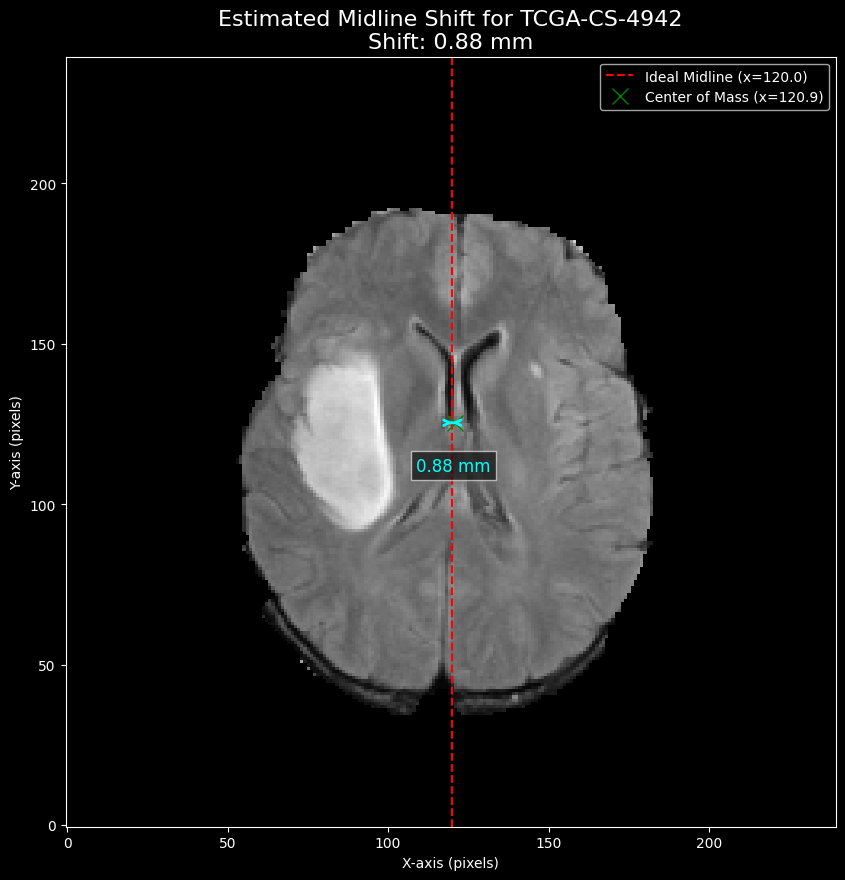

Processing patient 2/61: TCGA_CS_4944


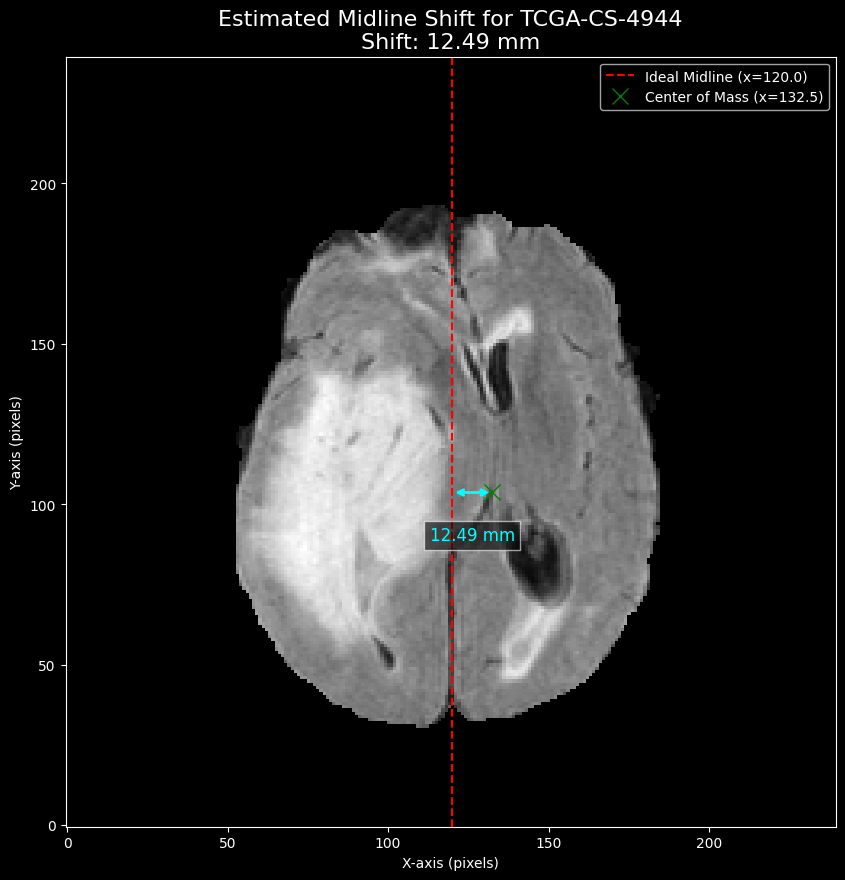

Processing patient 3/61: TCGA_CS_5393


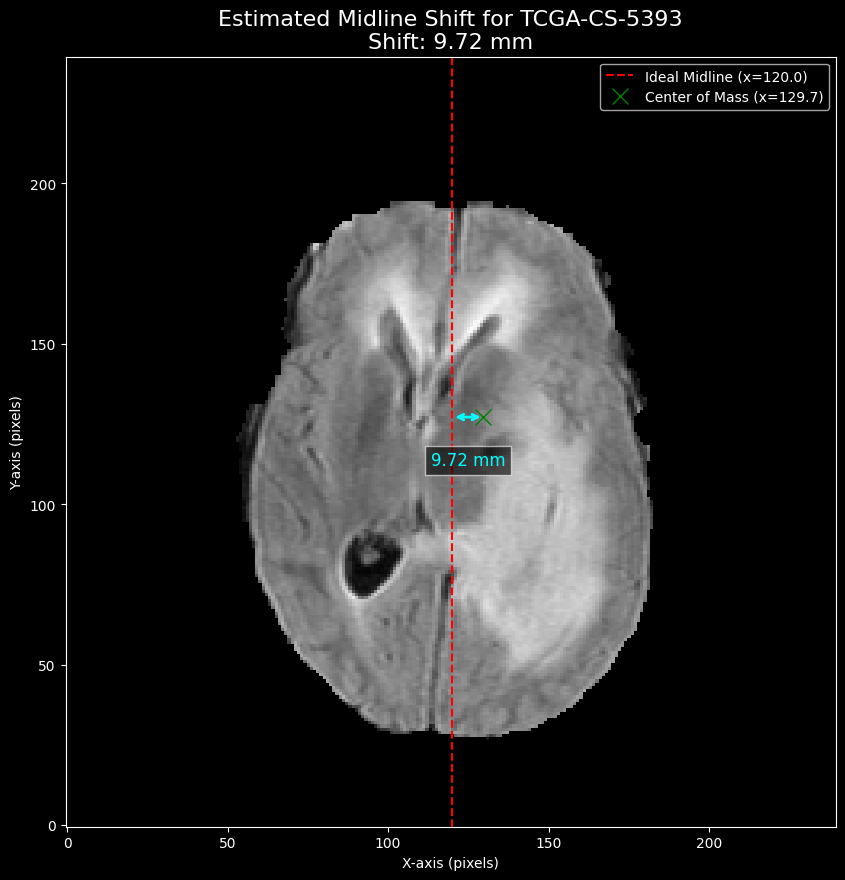

Processing patient 4/61: TCGA_CS_5396


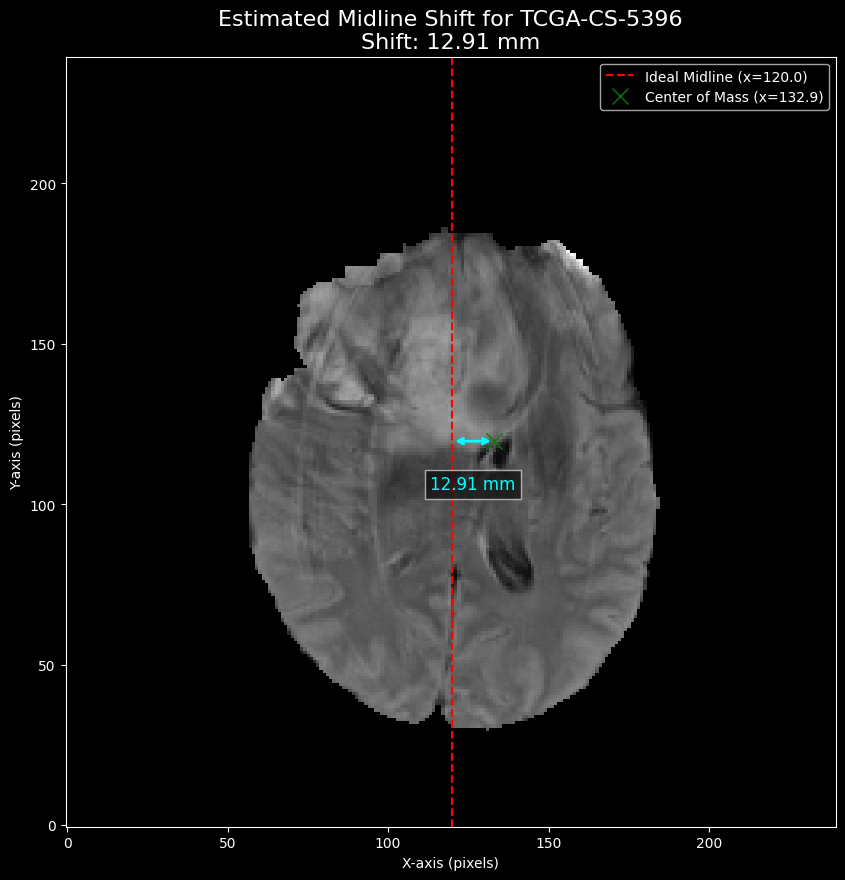

Processing patient 5/61: TCGA_CS_5397


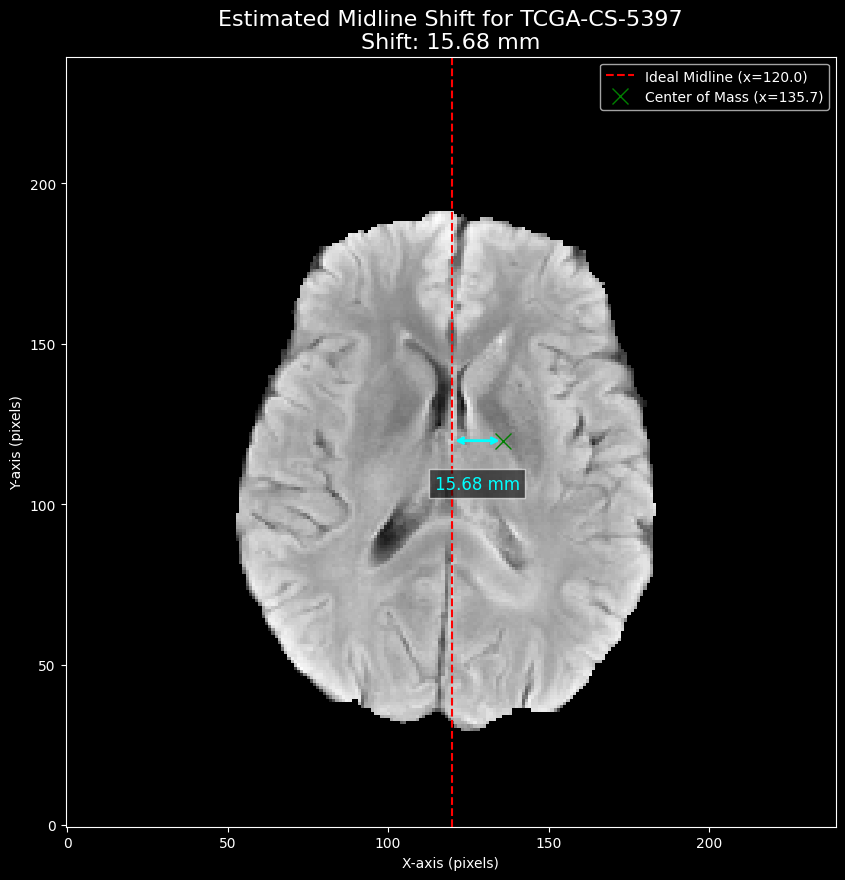

Processing patient 6/61: TCGA_CS_6186


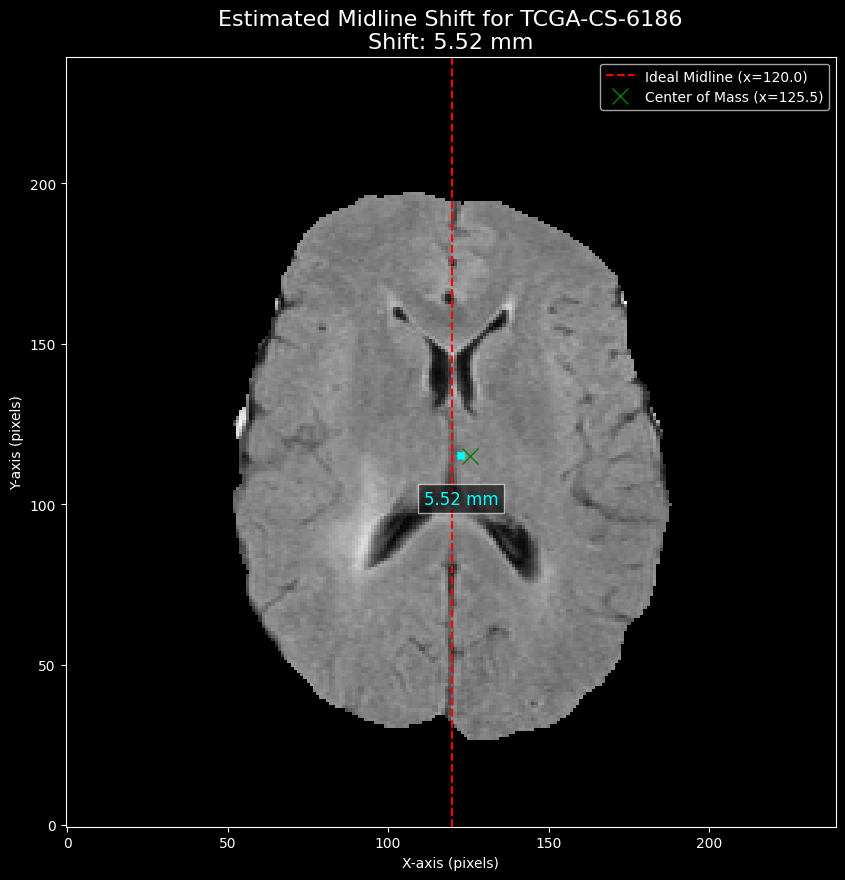

Processing patient 7/61: TCGA_CS_6188


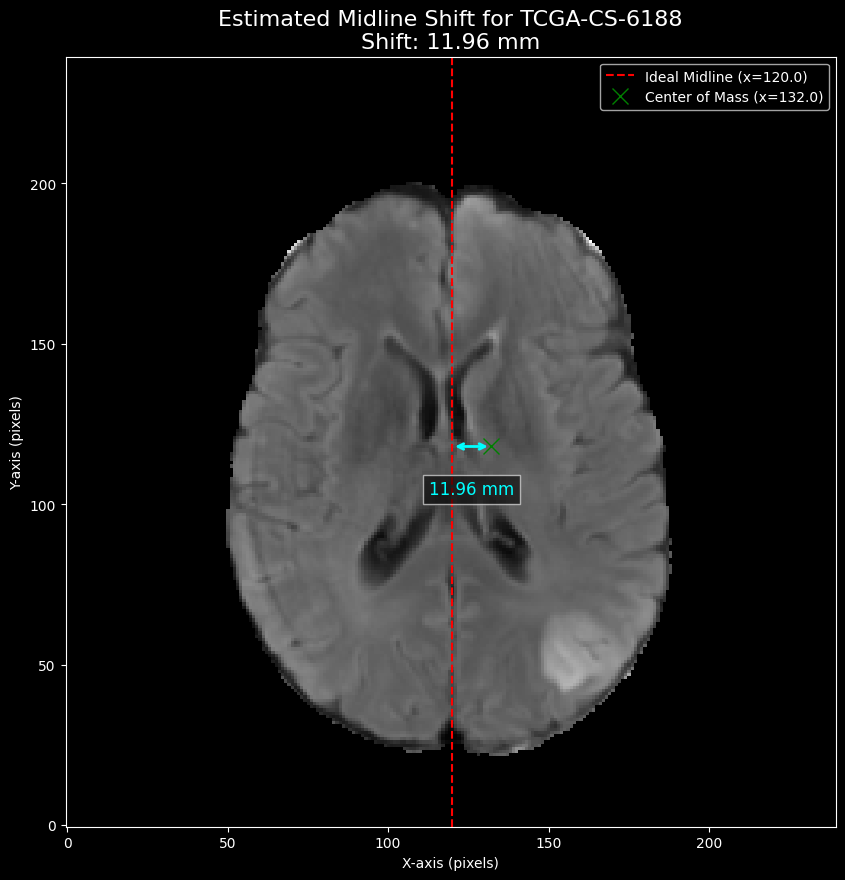

Processing patient 8/61: TCGA_CS_6665


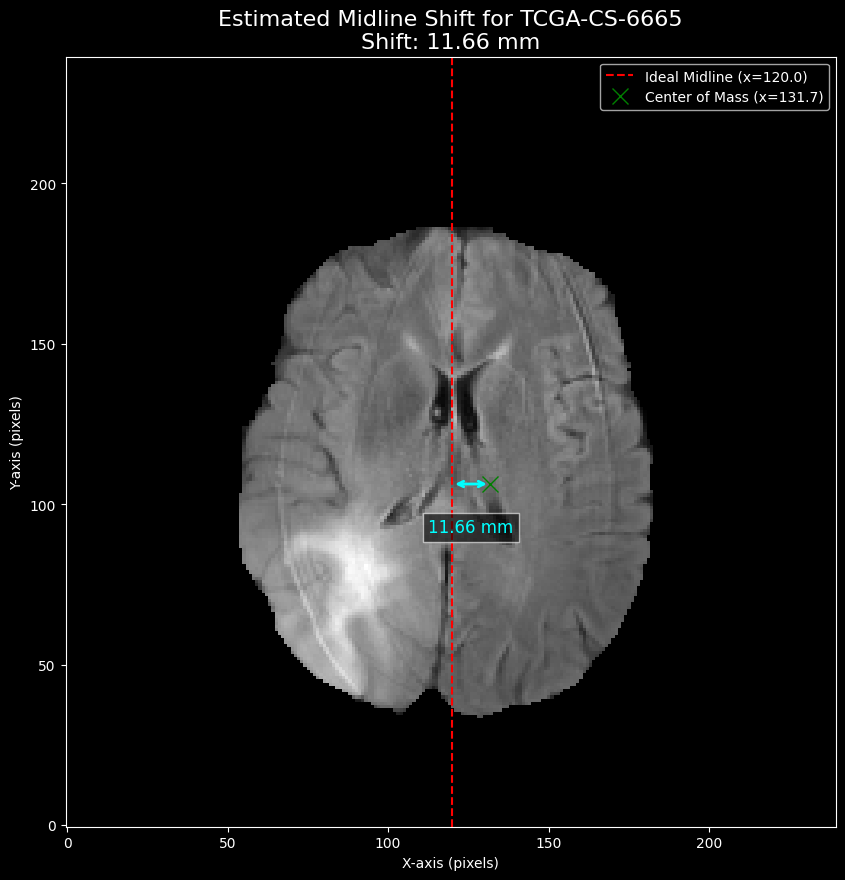

Processing patient 9/61: TCGA_CS_6666


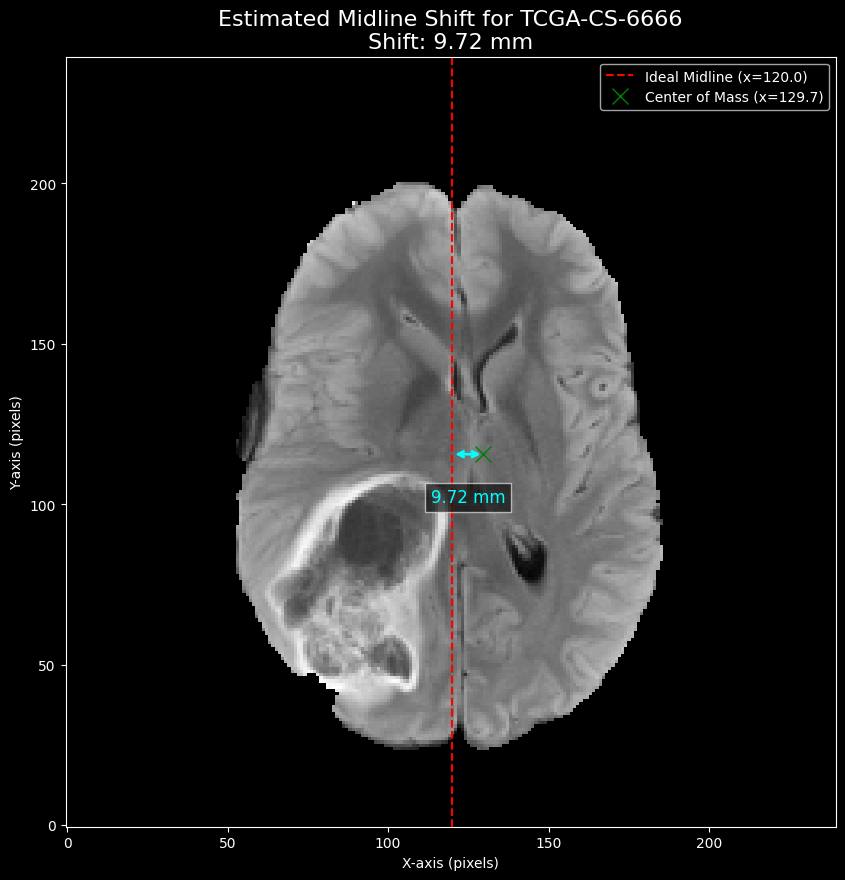

Processing patient 10/61: TCGA_CS_6668


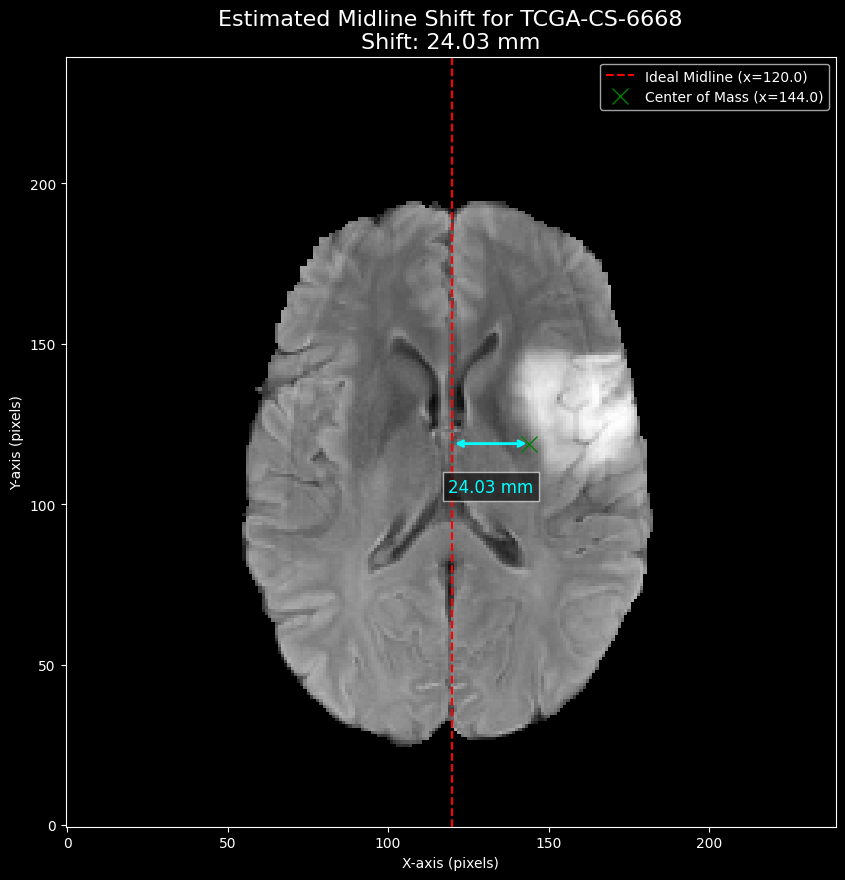

Processing patient 11/61: TCGA_CS_6669


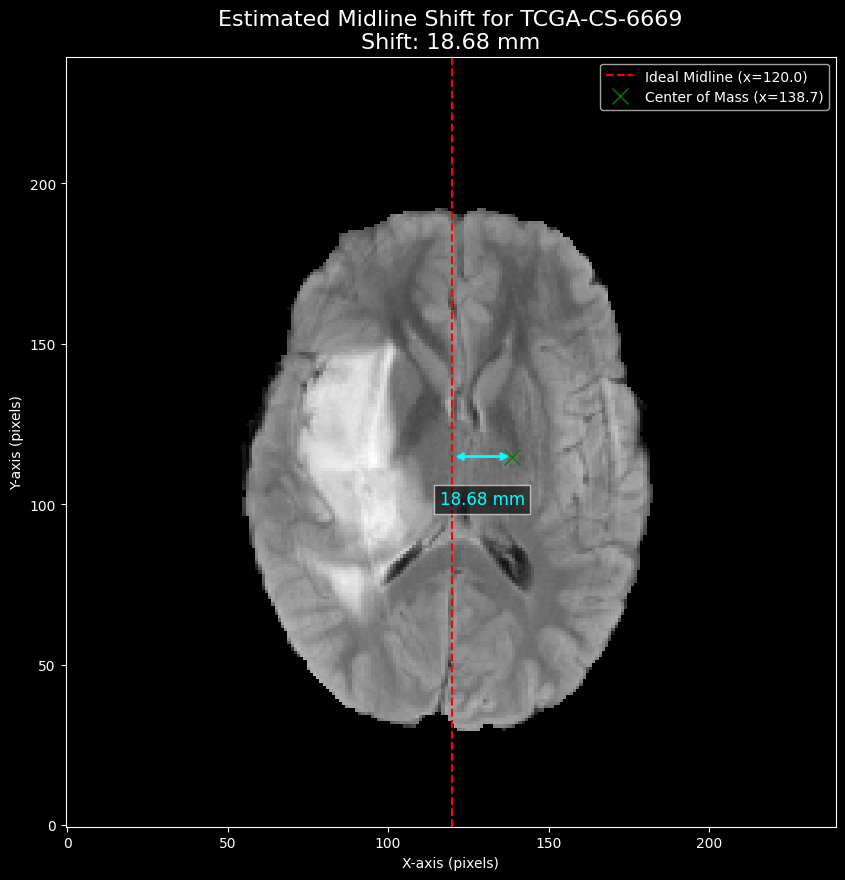

Processing patient 12/61: TCGA_DU_5851


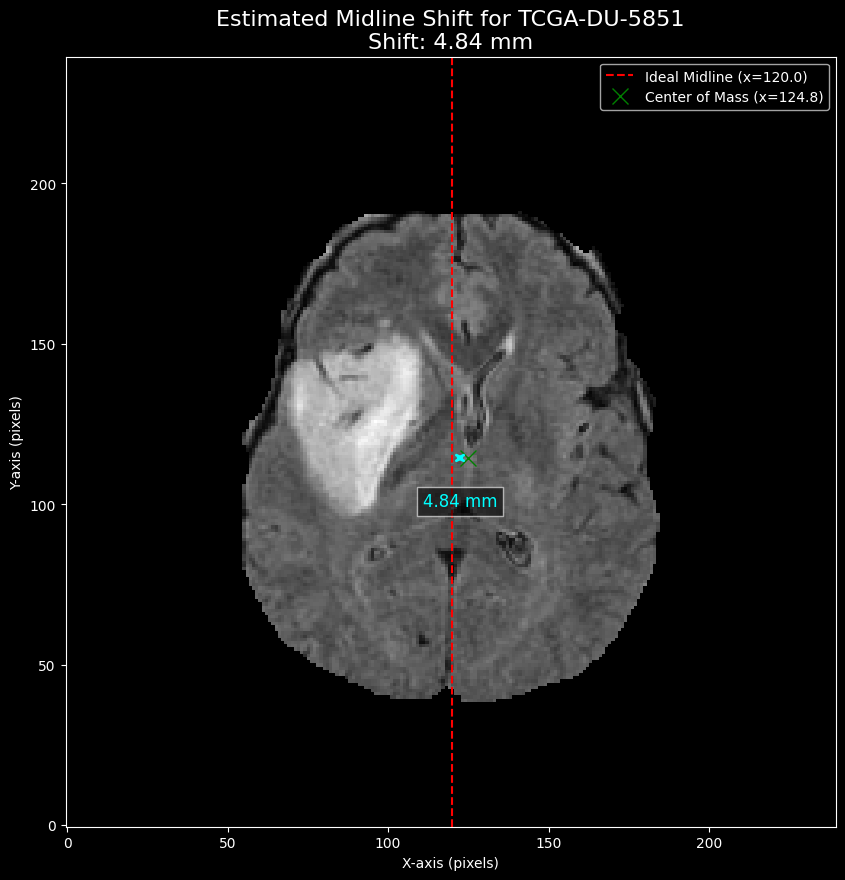

Processing patient 13/61: TCGA_DU_5854


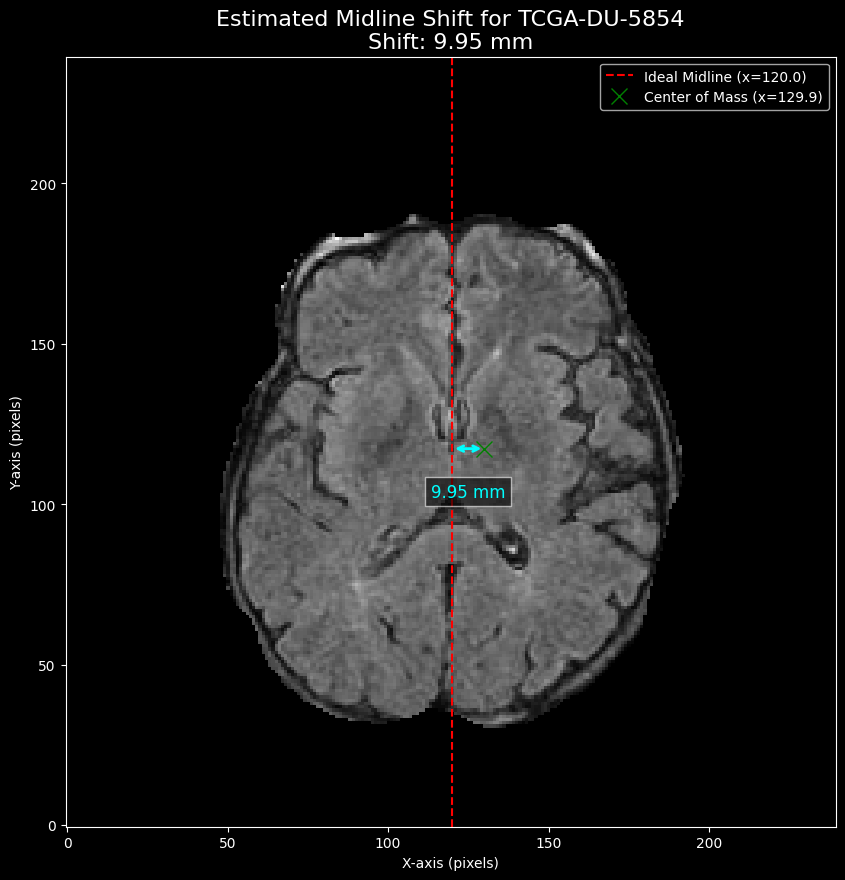

Processing patient 14/61: TCGA_DU_5855


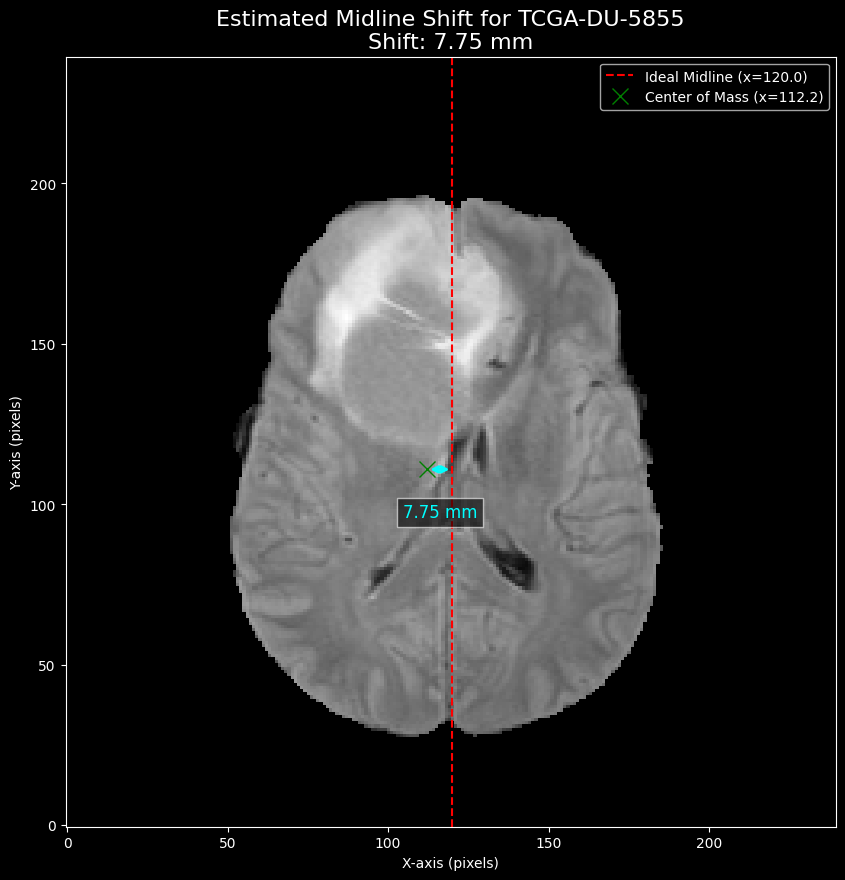

Processing patient 15/61: TCGA_DU_5872


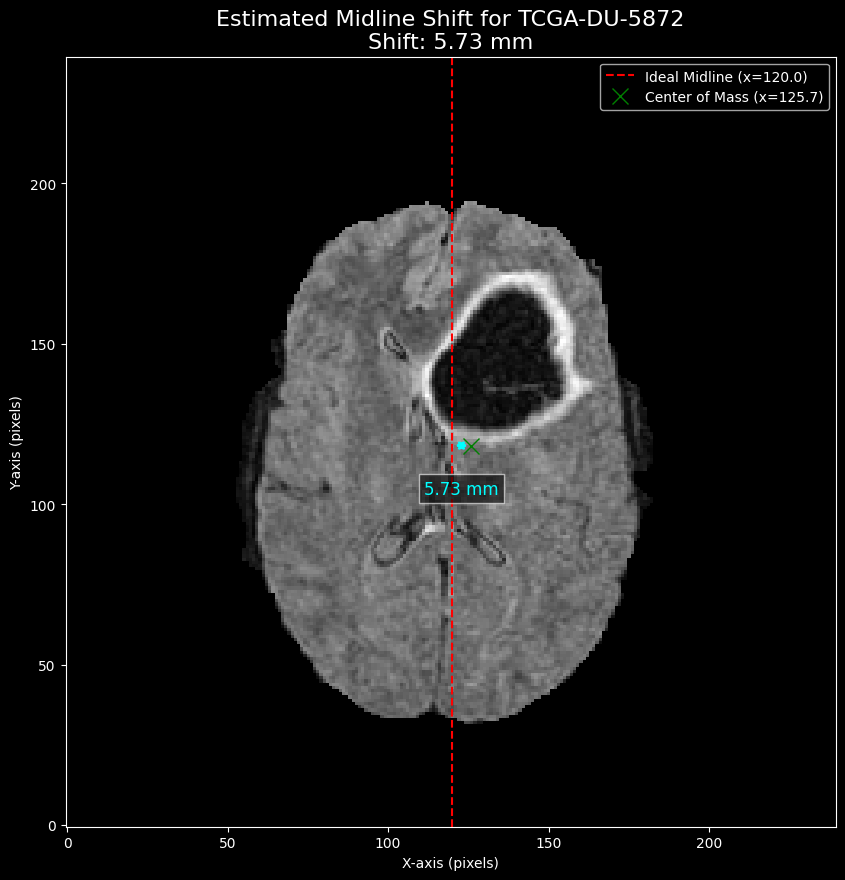

Processing patient 16/61: TCGA_DU_5874


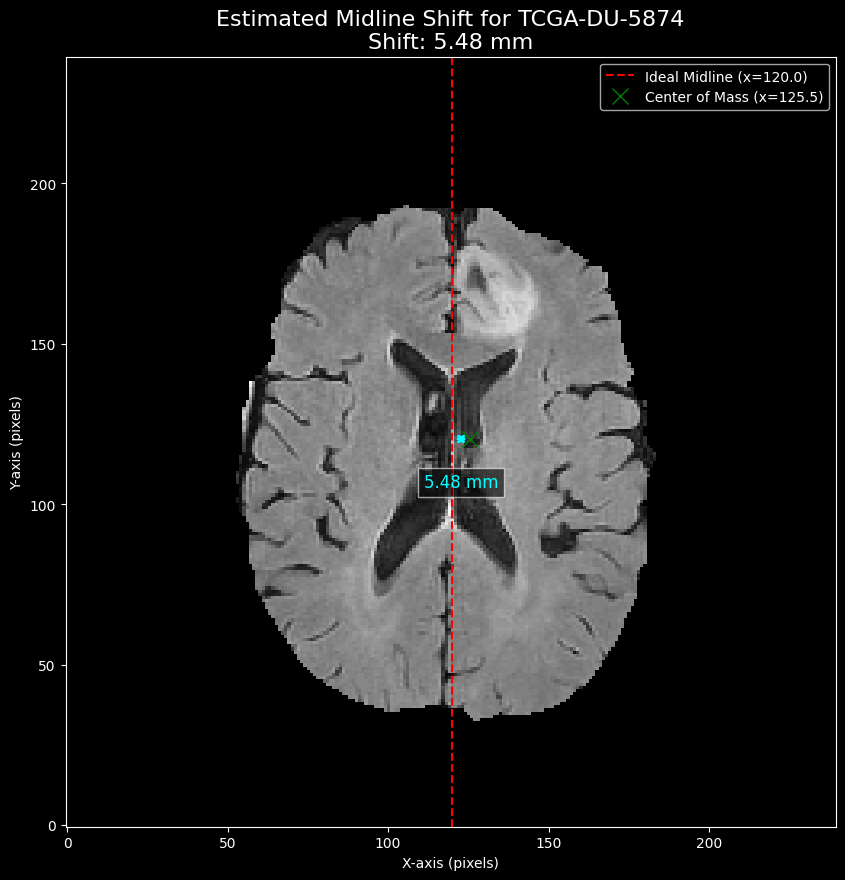

Processing patient 17/61: TCGA_DU_6404


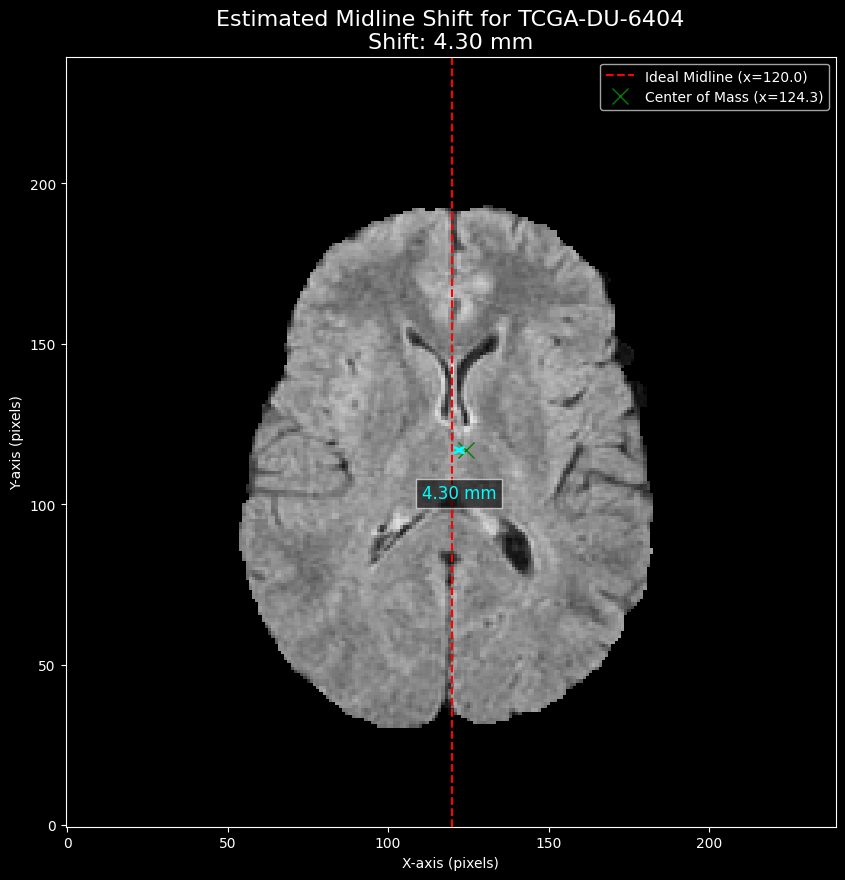

Processing patient 18/61: TCGA_DU_7008


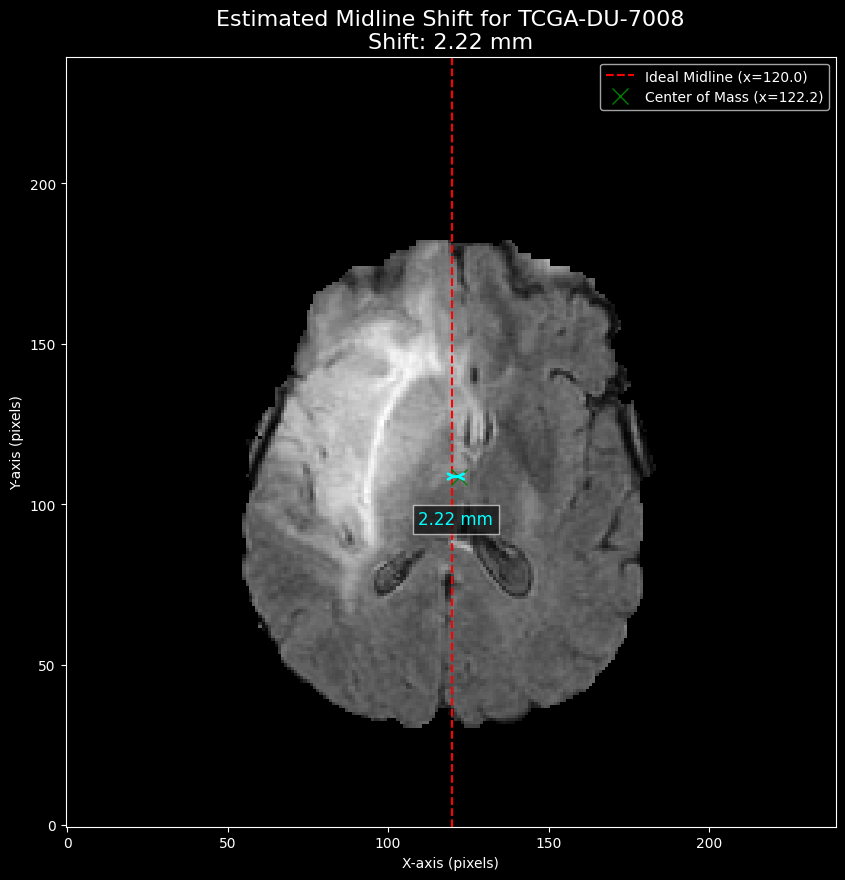

Processing patient 19/61: TCGA_DU_7010


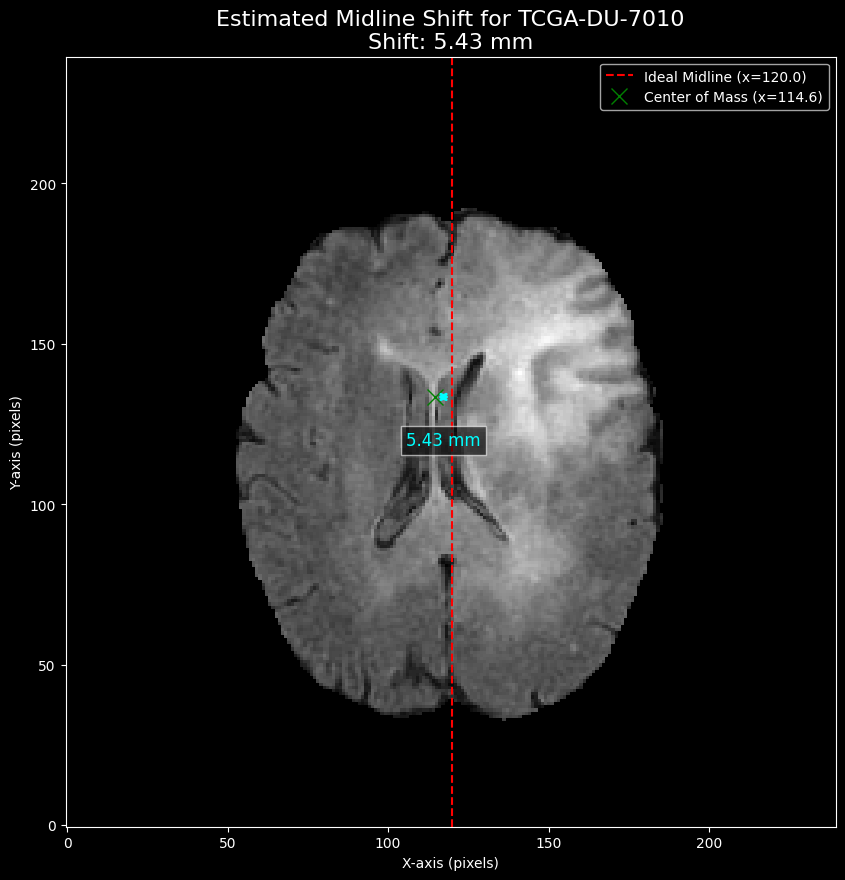

Processing patient 20/61: TCGA_DU_7014


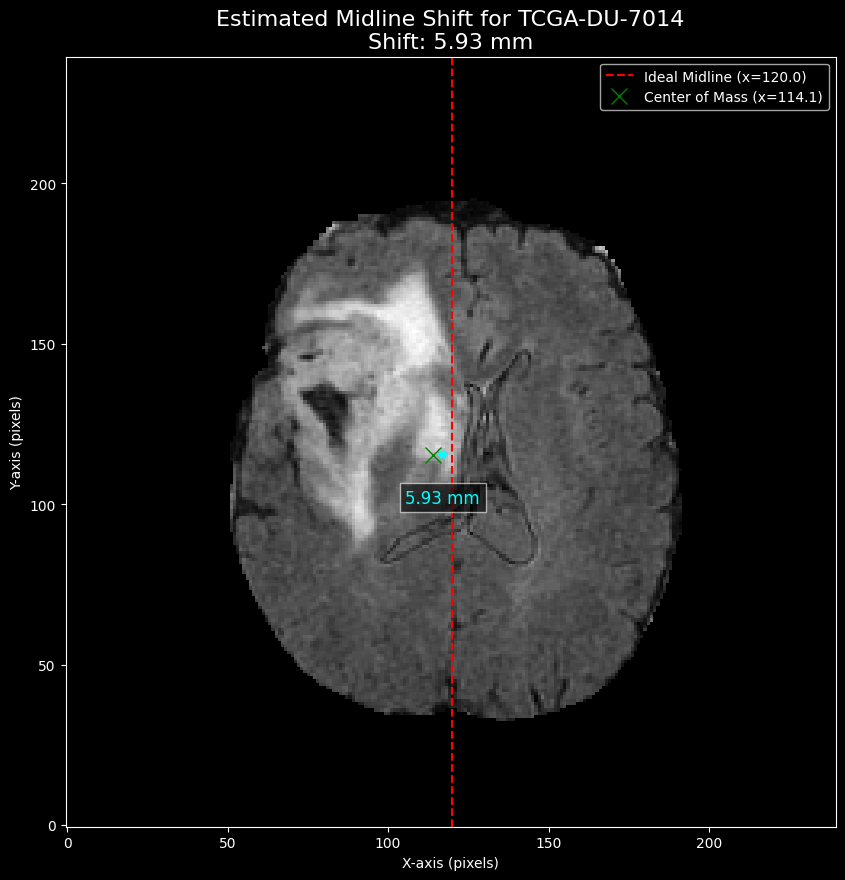

Processing patient 21/61: TCGA_DU_7018


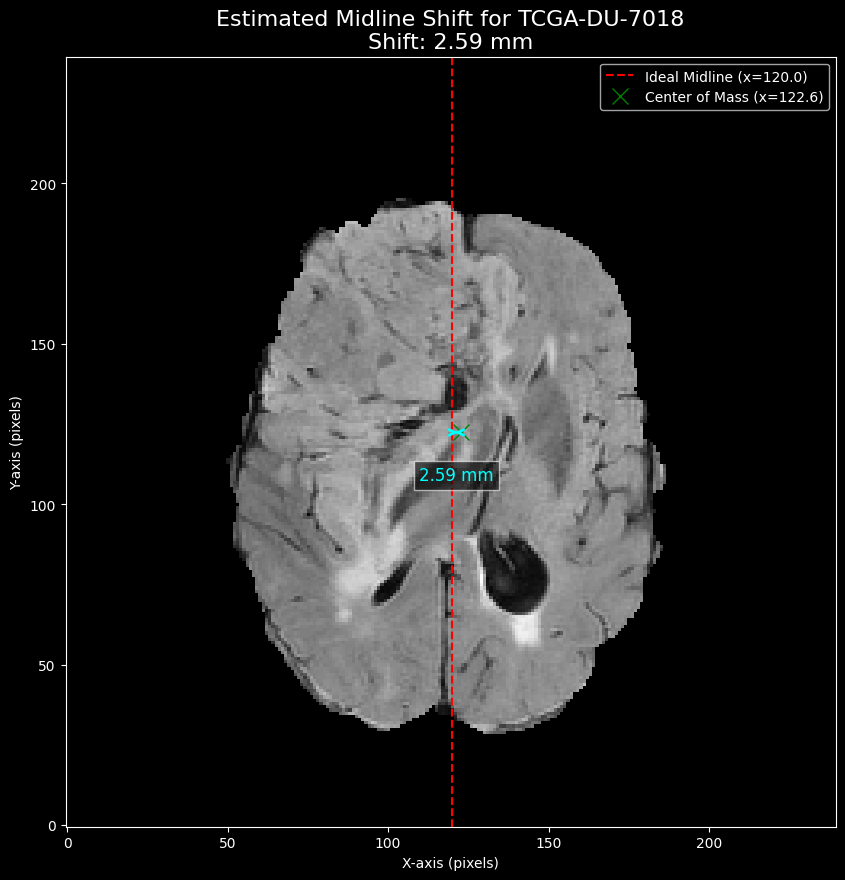

Processing patient 22/61: TCGA_DU_7019


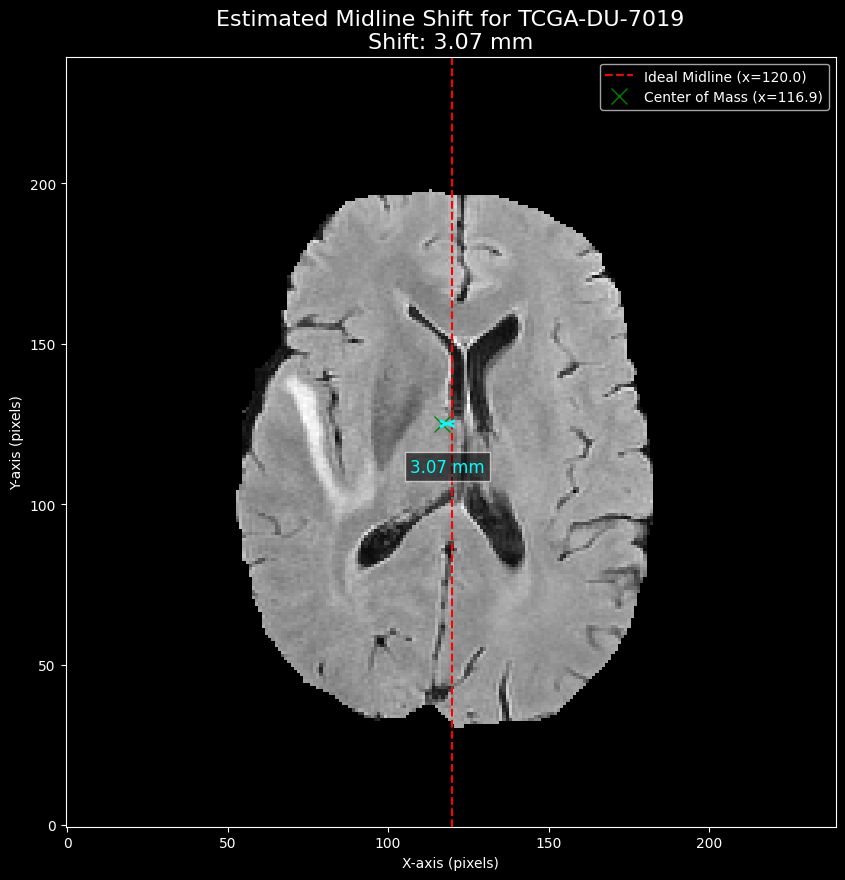

Processing patient 23/61: TCGA_DU_7294


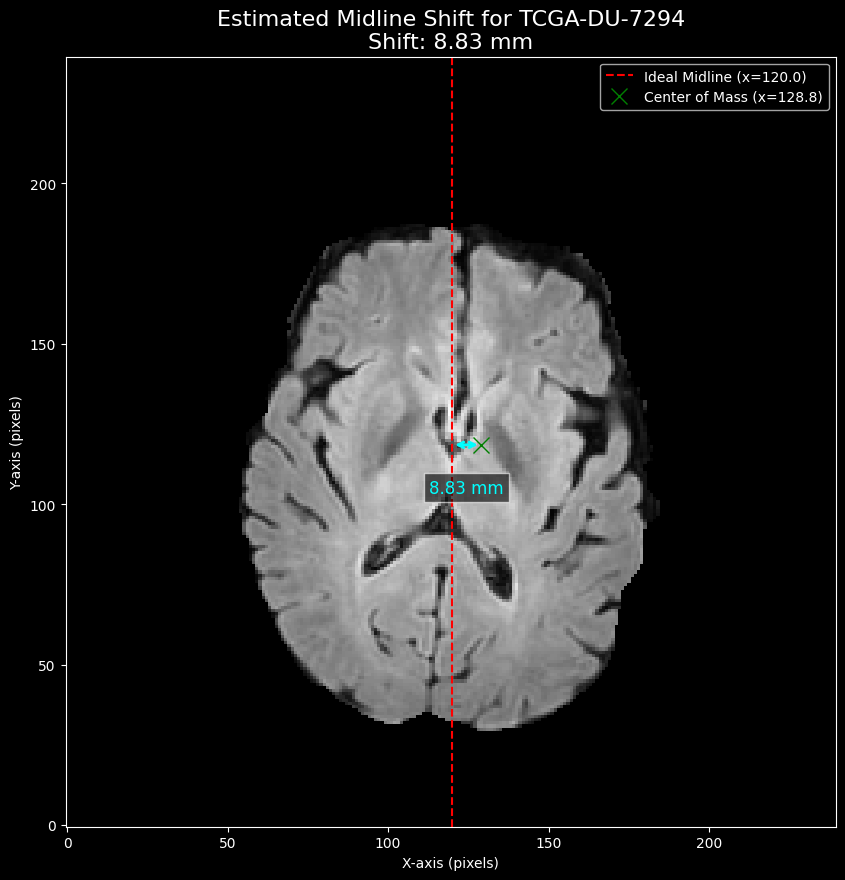

Processing patient 24/61: TCGA_DU_7298


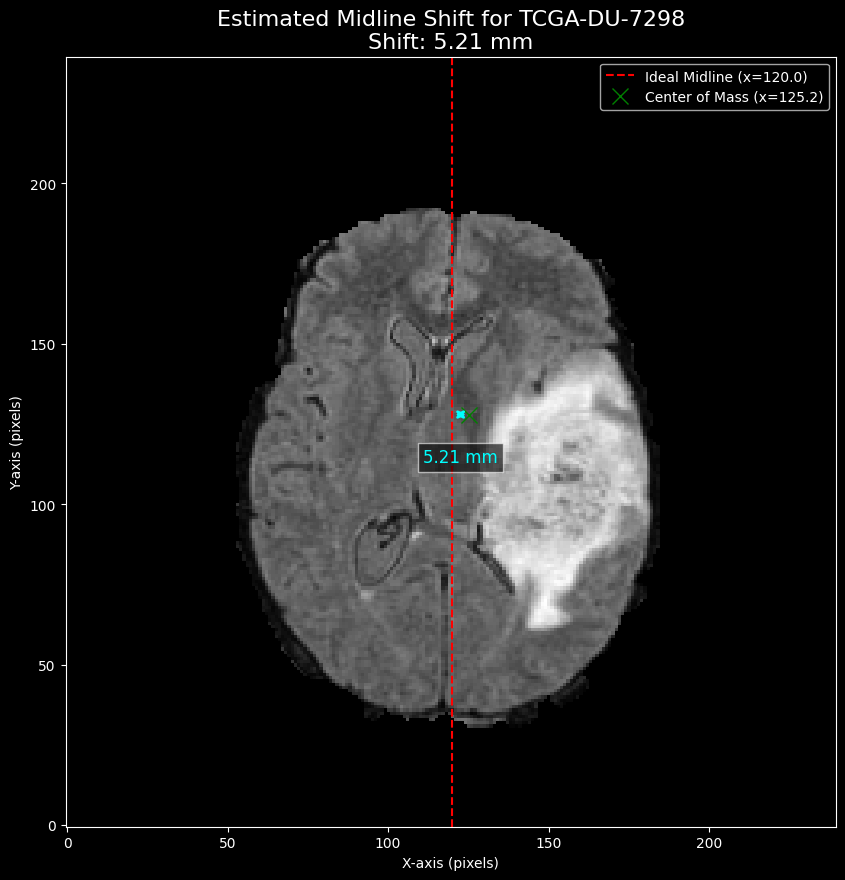

Processing patient 25/61: TCGA_DU_7299


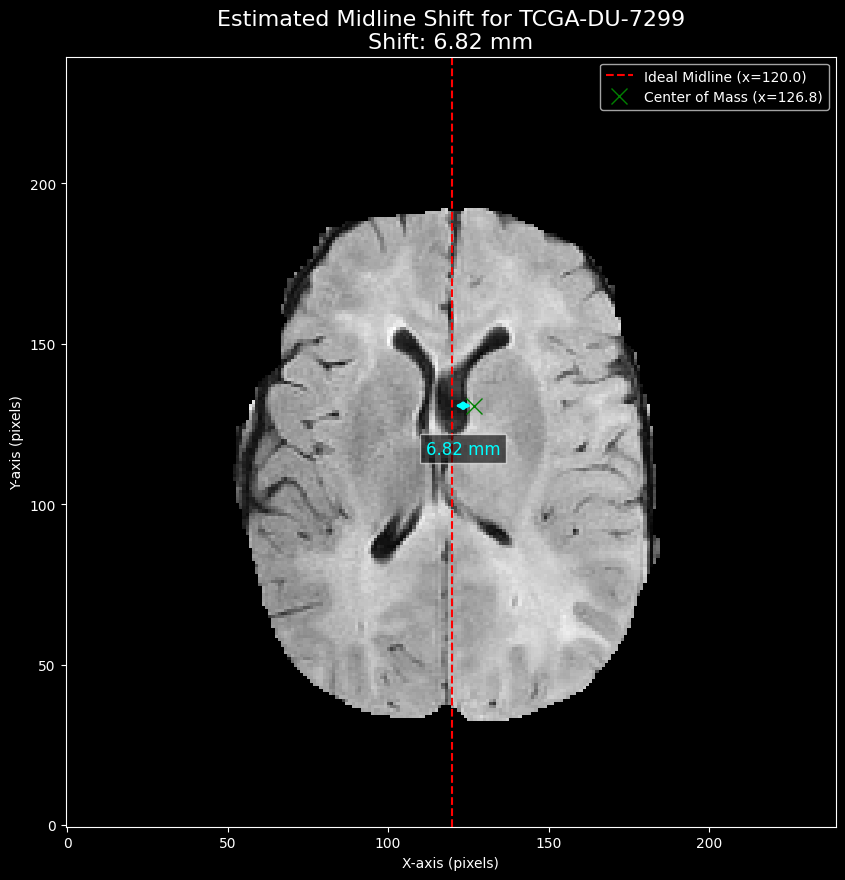

Processing patient 26/61: TCGA_DU_7300


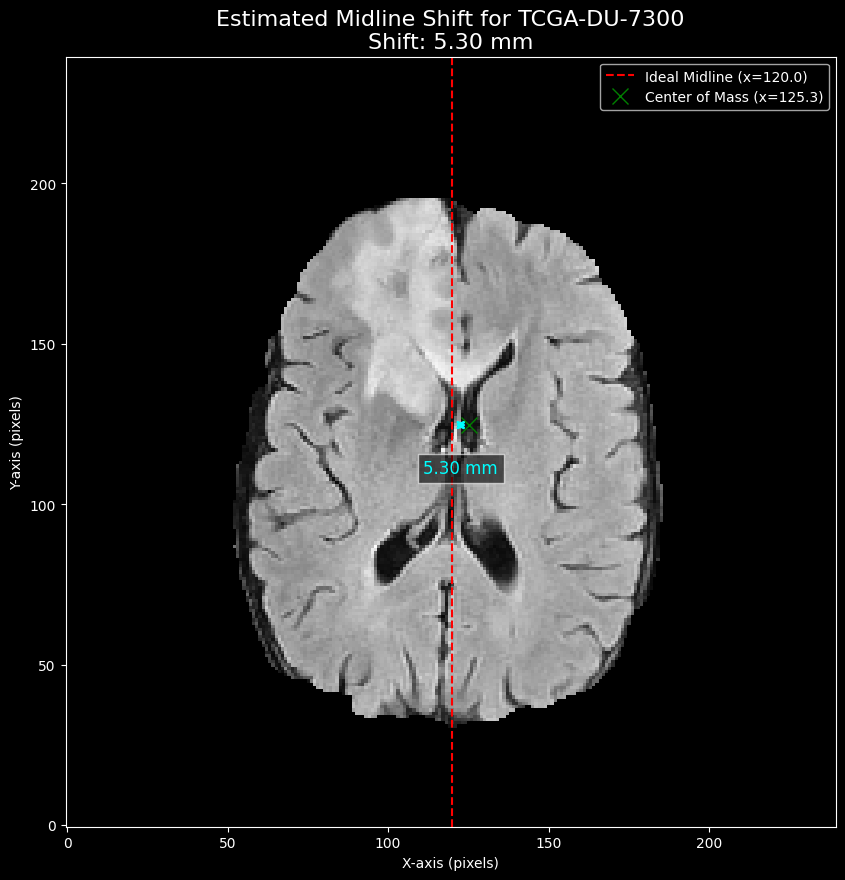

Processing patient 27/61: TCGA_DU_7301


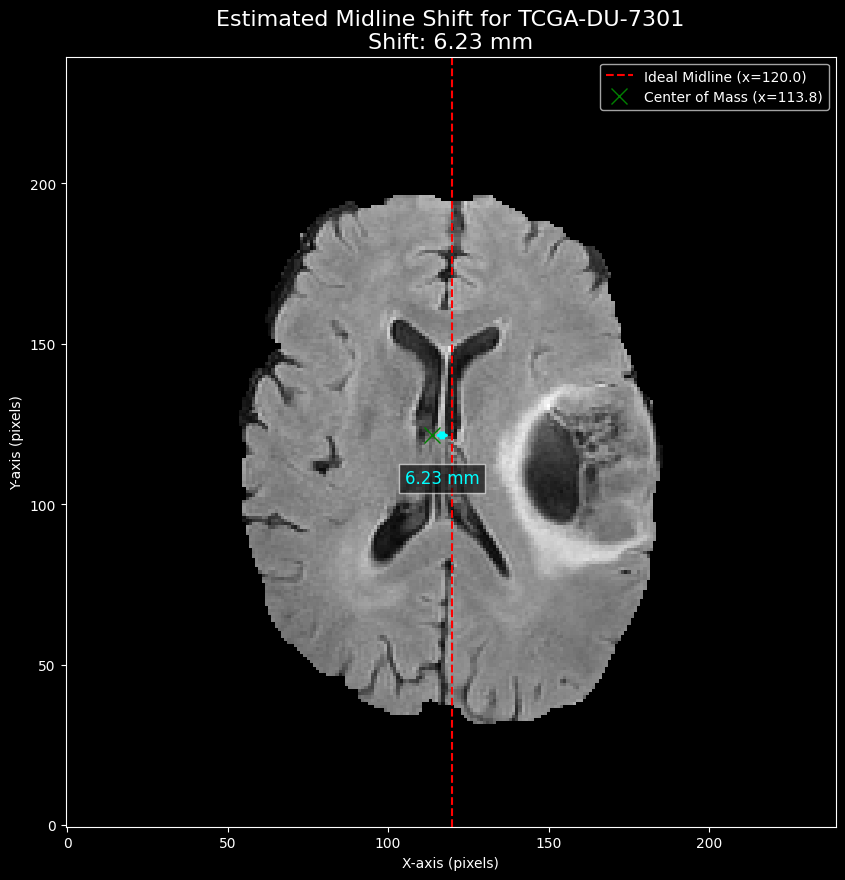

Processing patient 28/61: TCGA_DU_7302


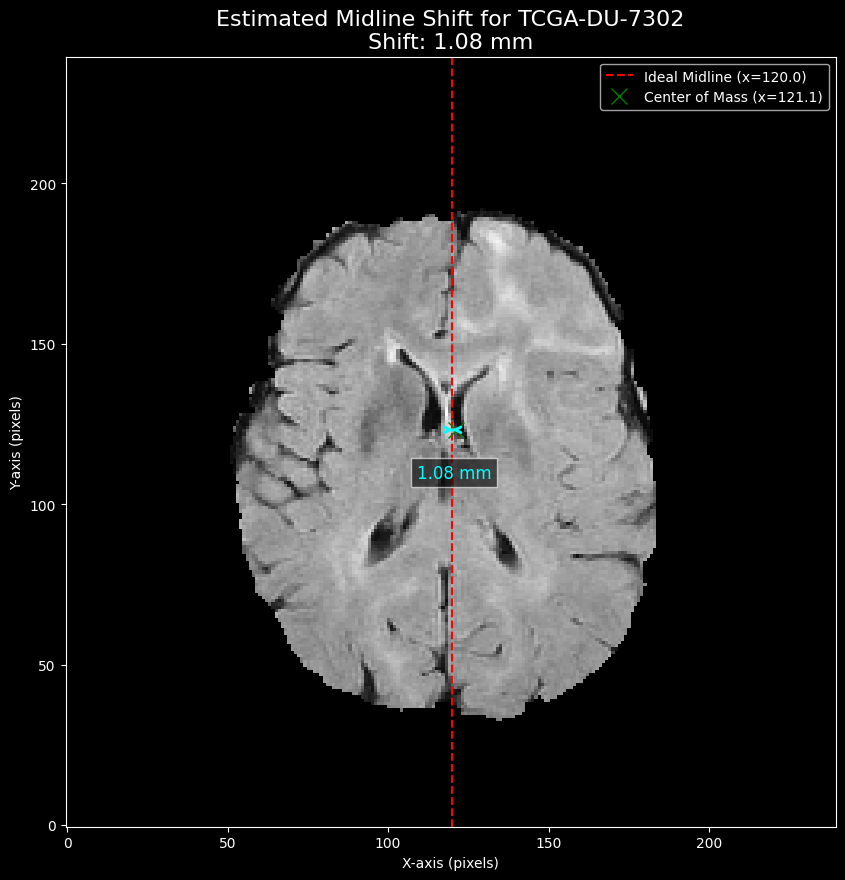

Processing patient 29/61: TCGA_DU_7304


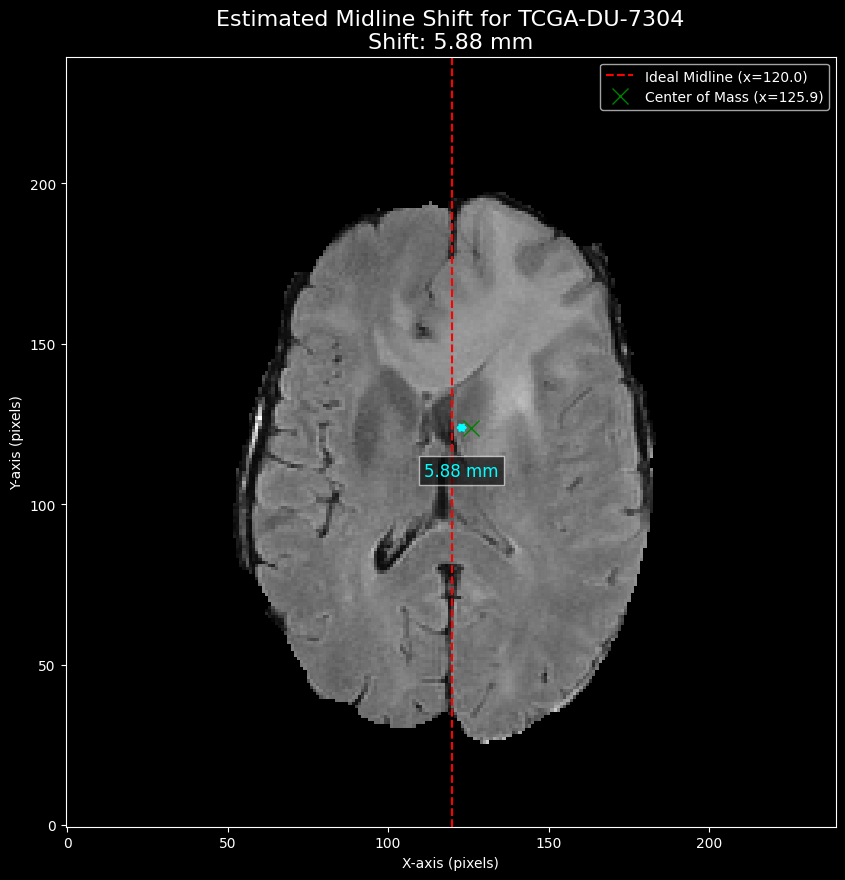

Processing patient 30/61: TCGA_DU_7306


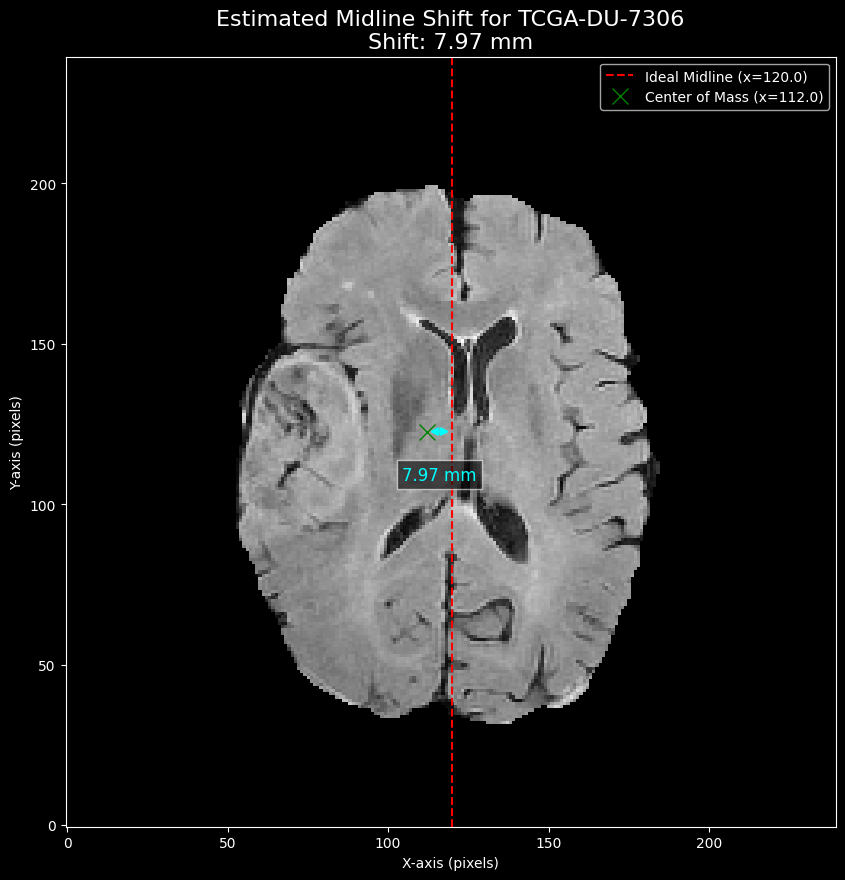

Processing patient 31/61: TCGA_DU_7309


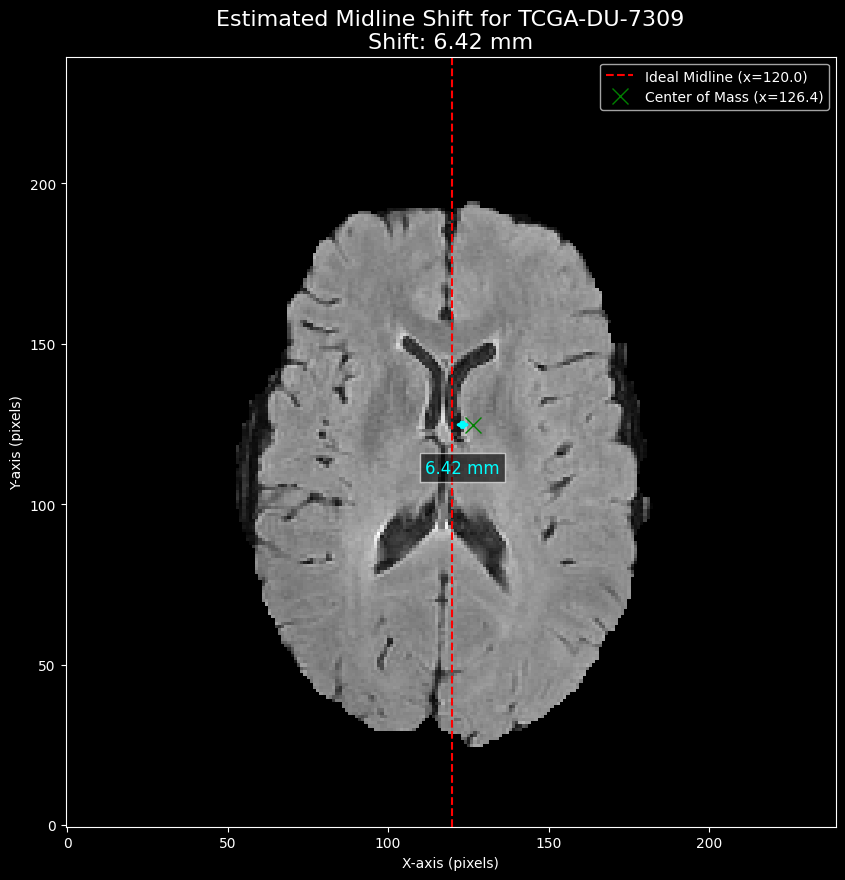

Processing patient 32/61: TCGA_DU_8162


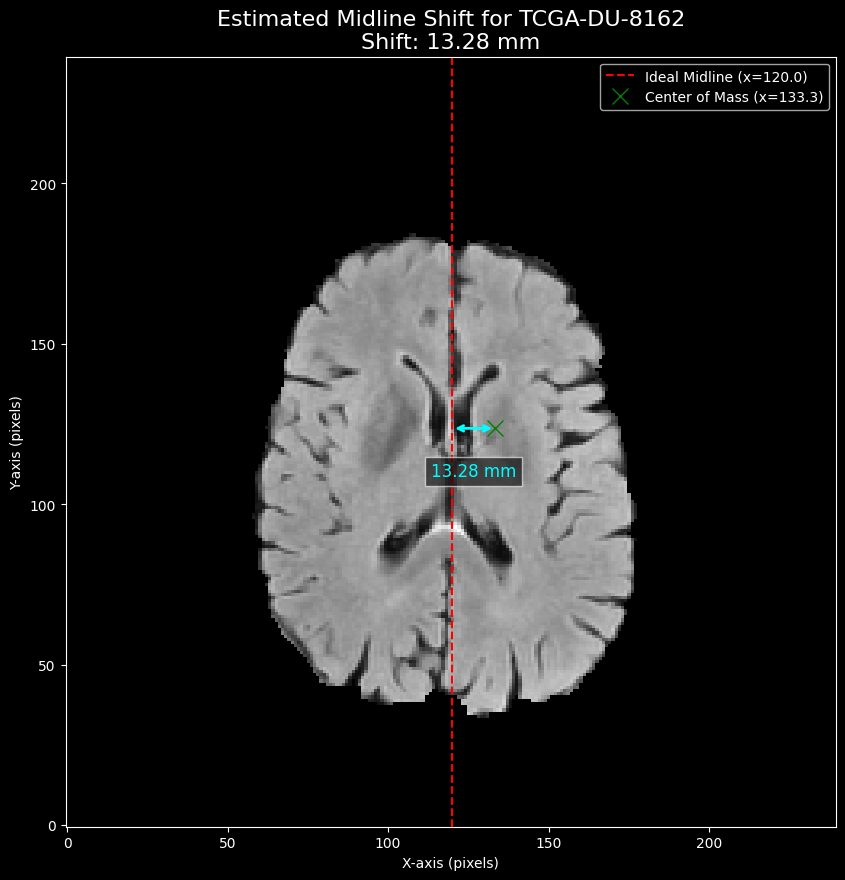

Processing patient 33/61: TCGA_DU_8164


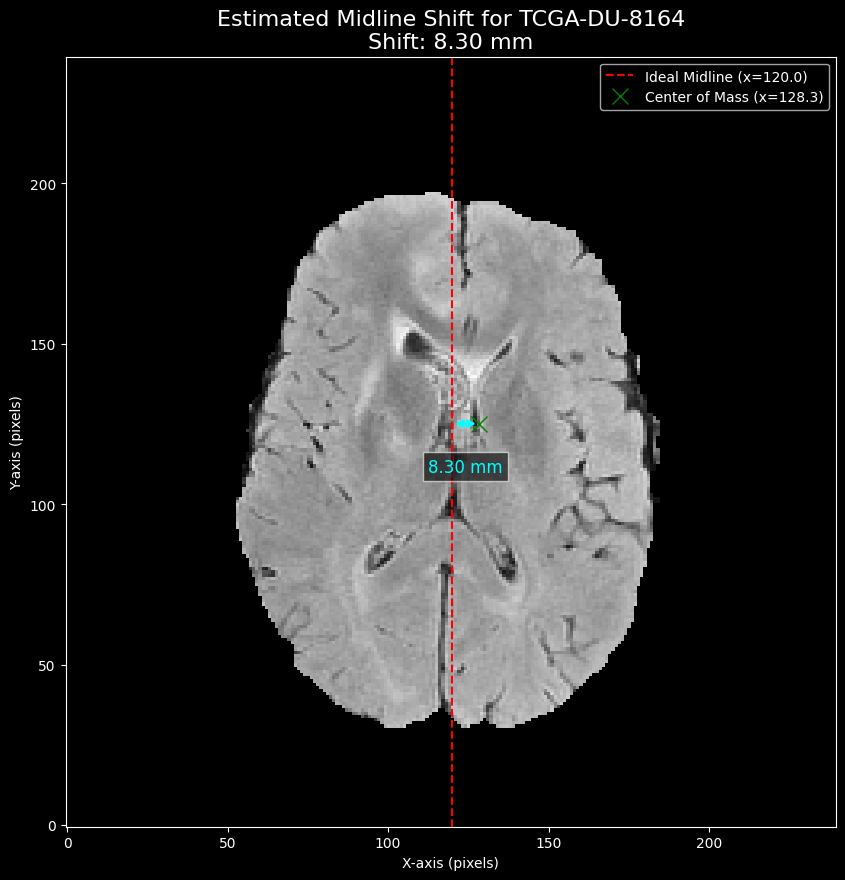

Processing patient 34/61: TCGA_DU_8166


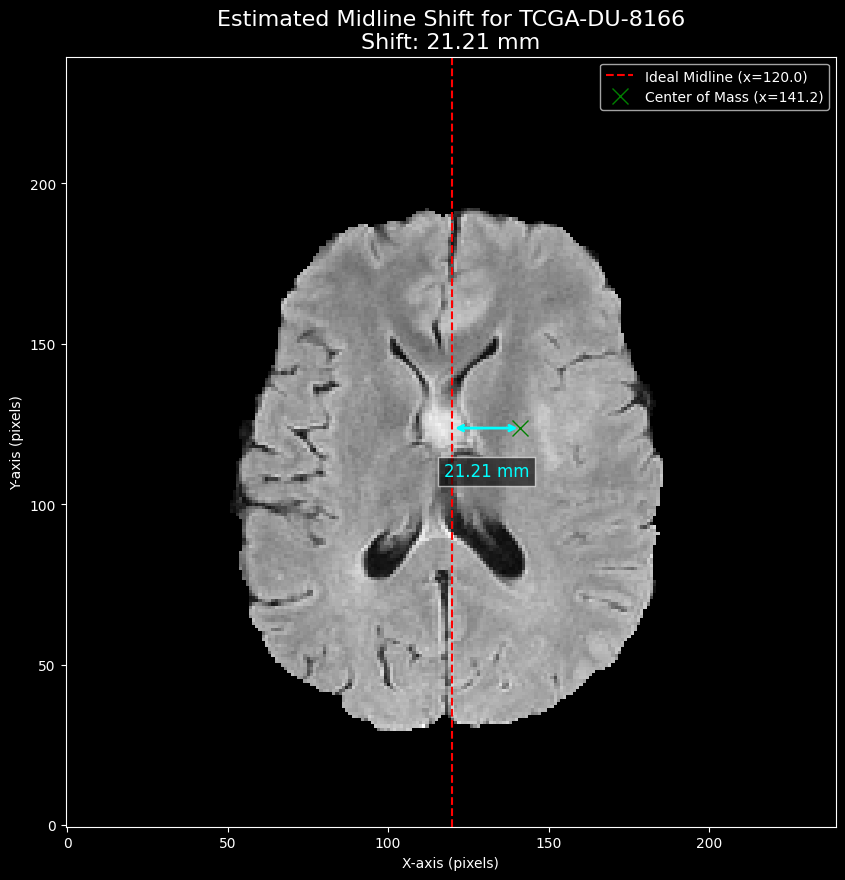

Processing patient 35/61: TCGA_DU_8167


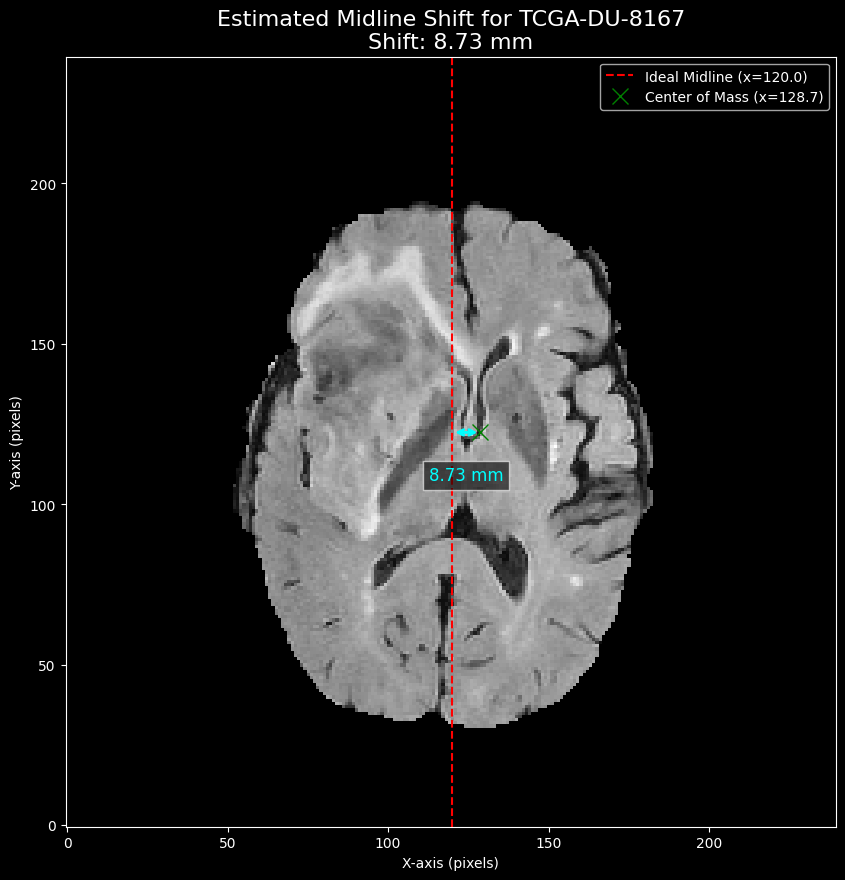

Processing patient 36/61: TCGA_DU_8168


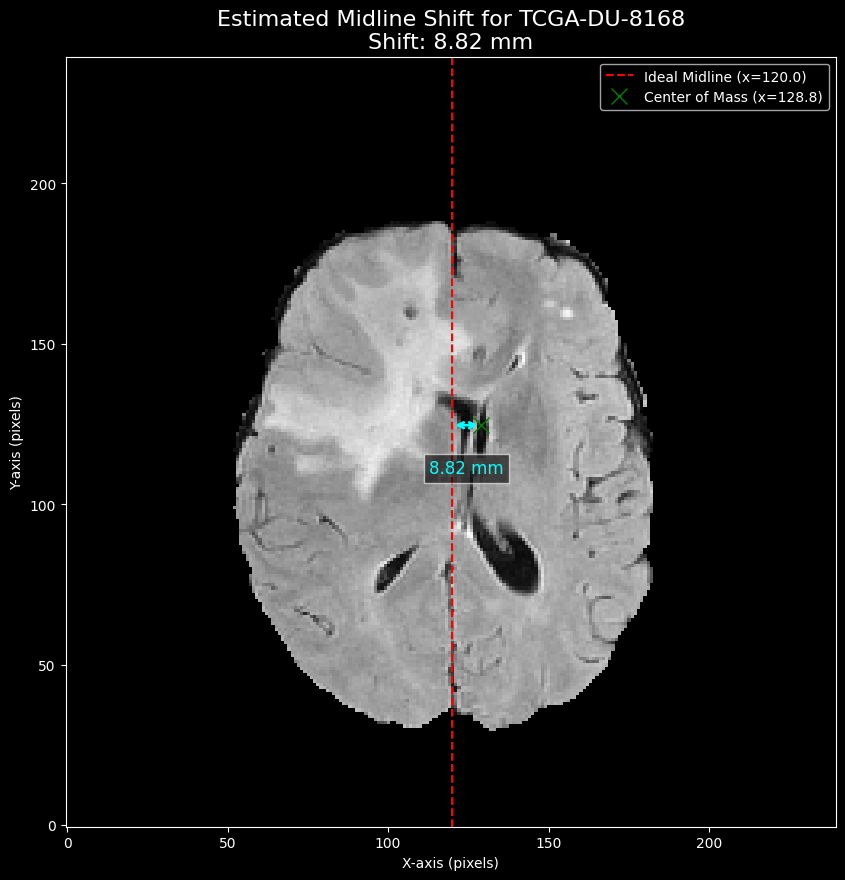

Processing patient 37/61: TCGA_DU_A5TR


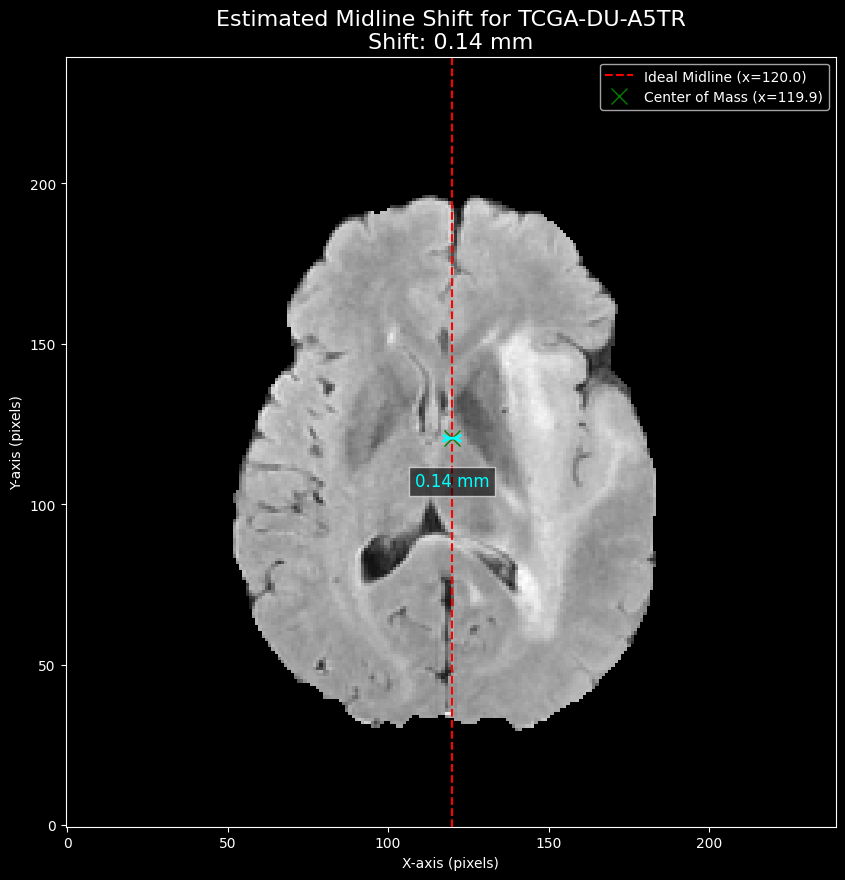

Processing patient 38/61: TCGA_DU_A5TS


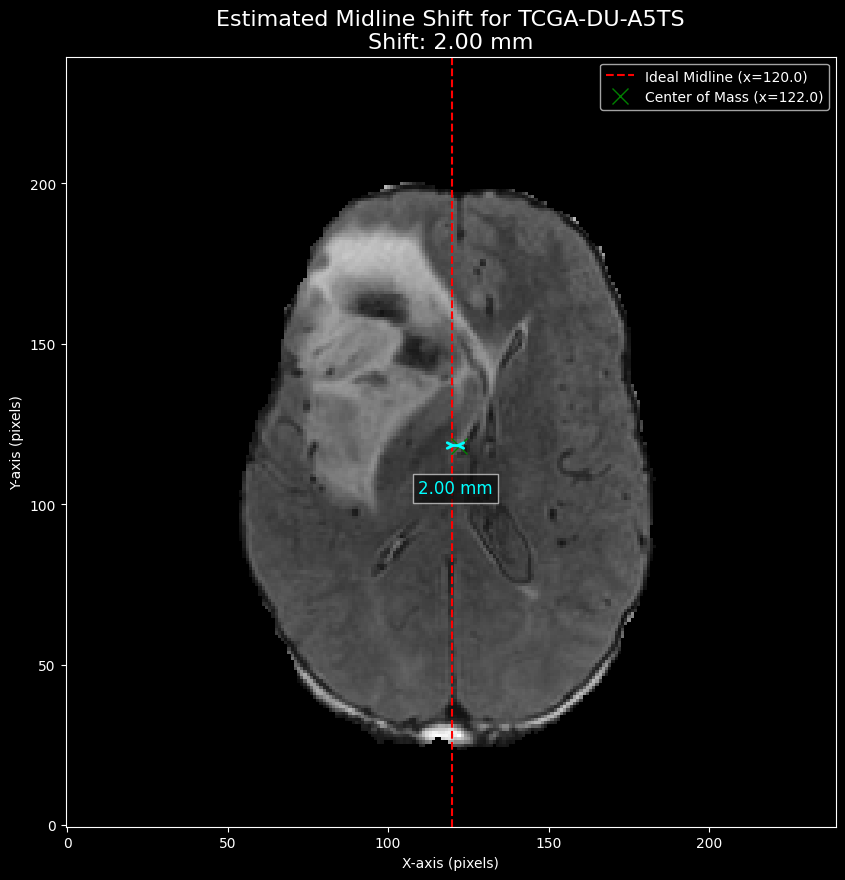

Processing patient 39/61: TCGA_DU_A5TT


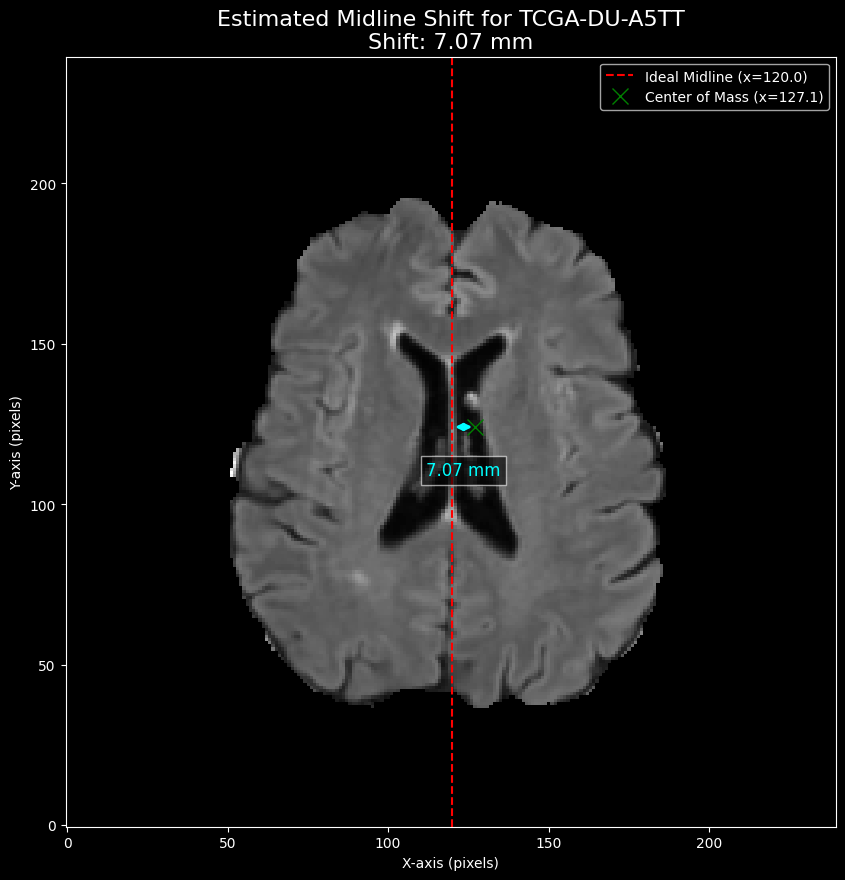

Processing patient 40/61: TCGA_DU_A5TU


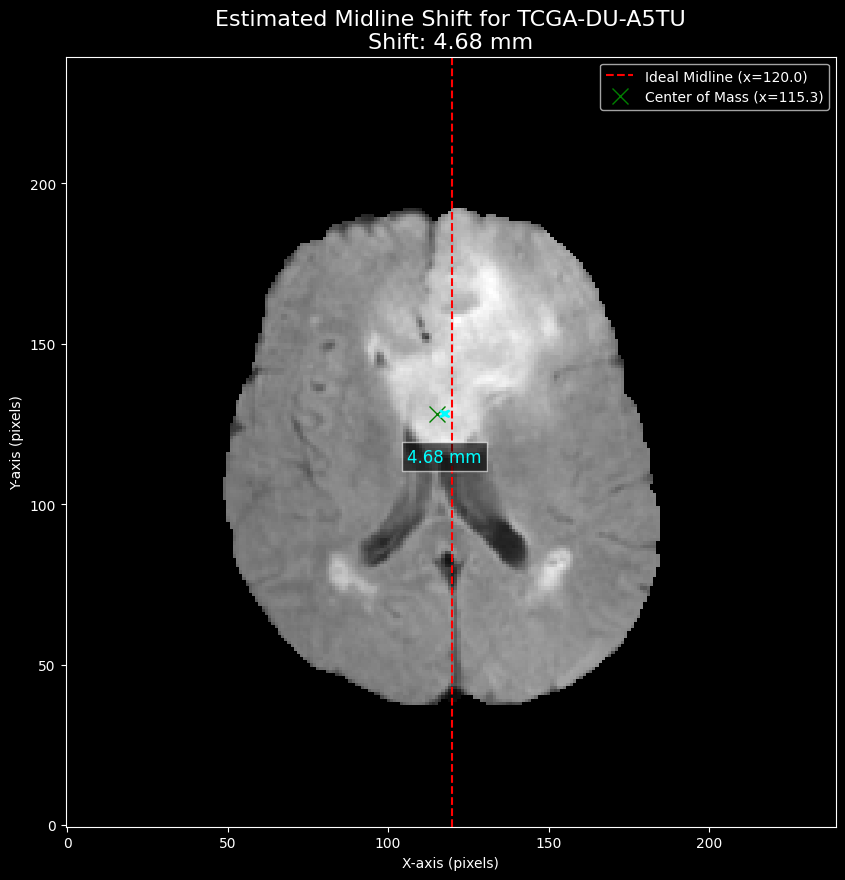

Processing patient 41/61: TCGA_DU_A5TW


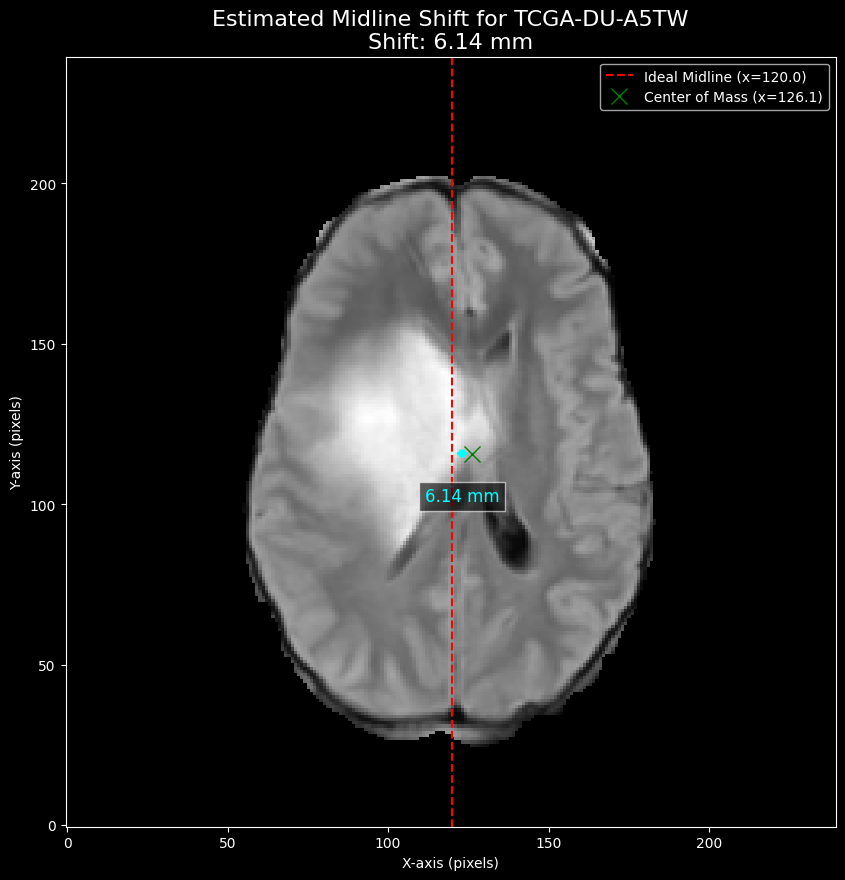

Processing patient 42/61: TCGA_DU_A5TY


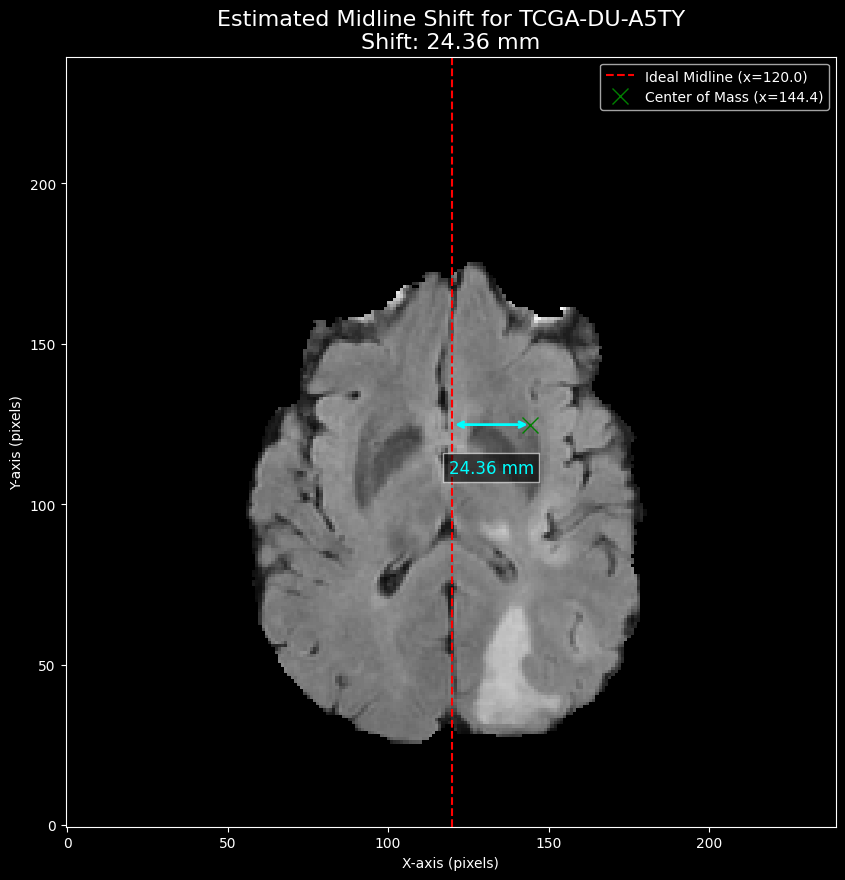

Processing patient 43/61: TCGA_FG_5964


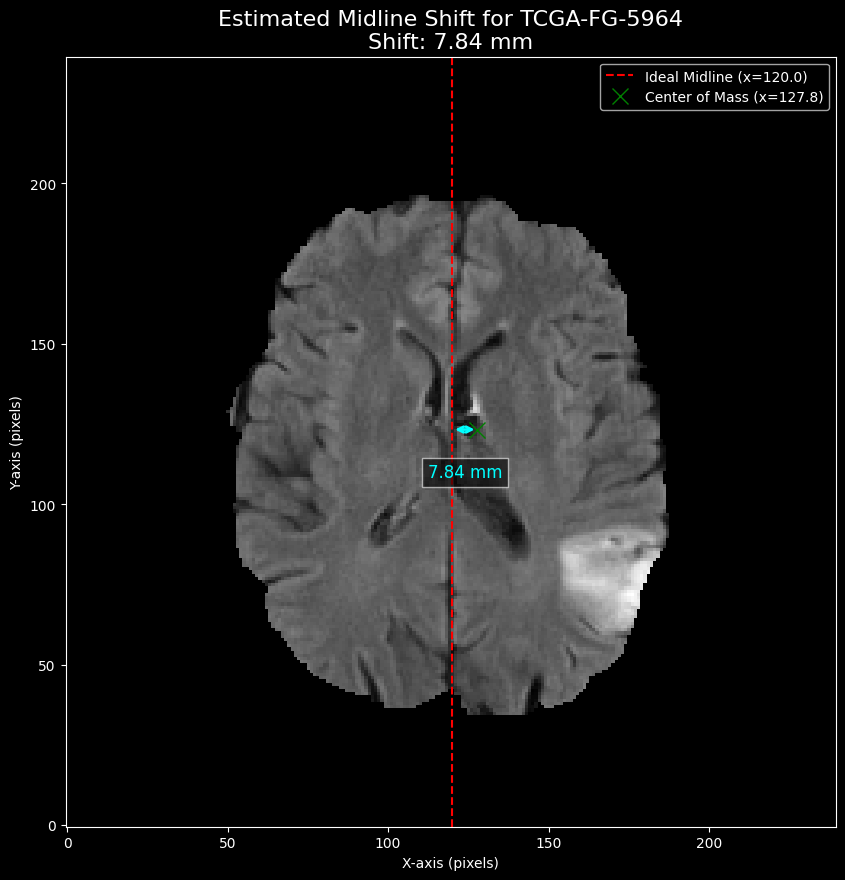

Processing patient 44/61: TCGA_FG_6689


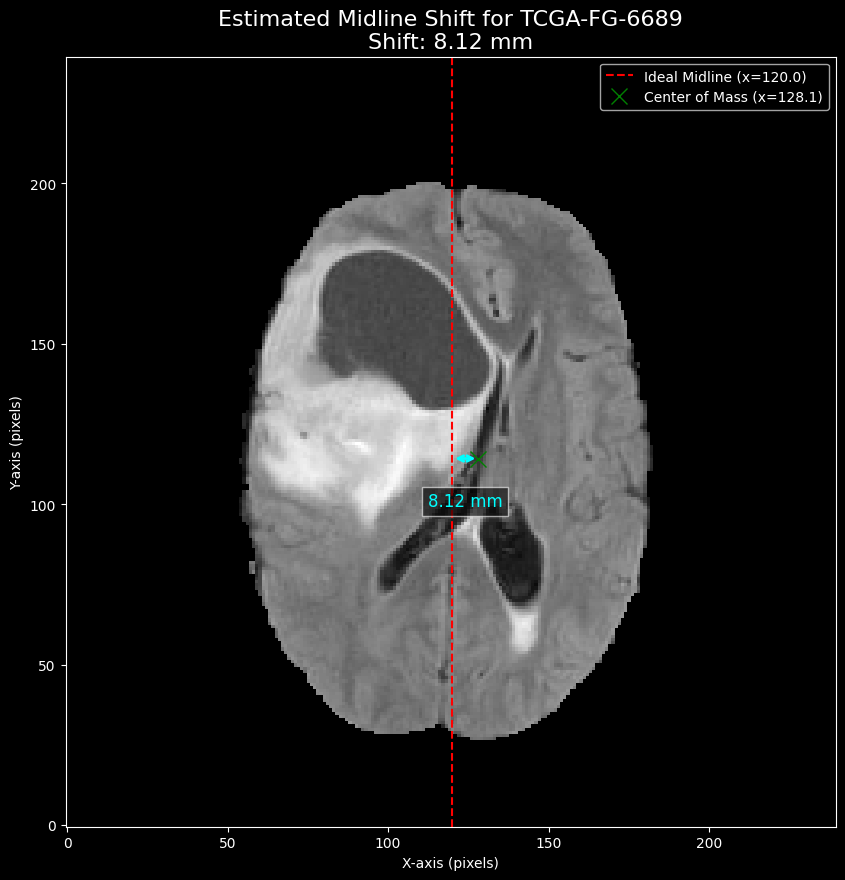

Processing patient 45/61: TCGA_FG_6691


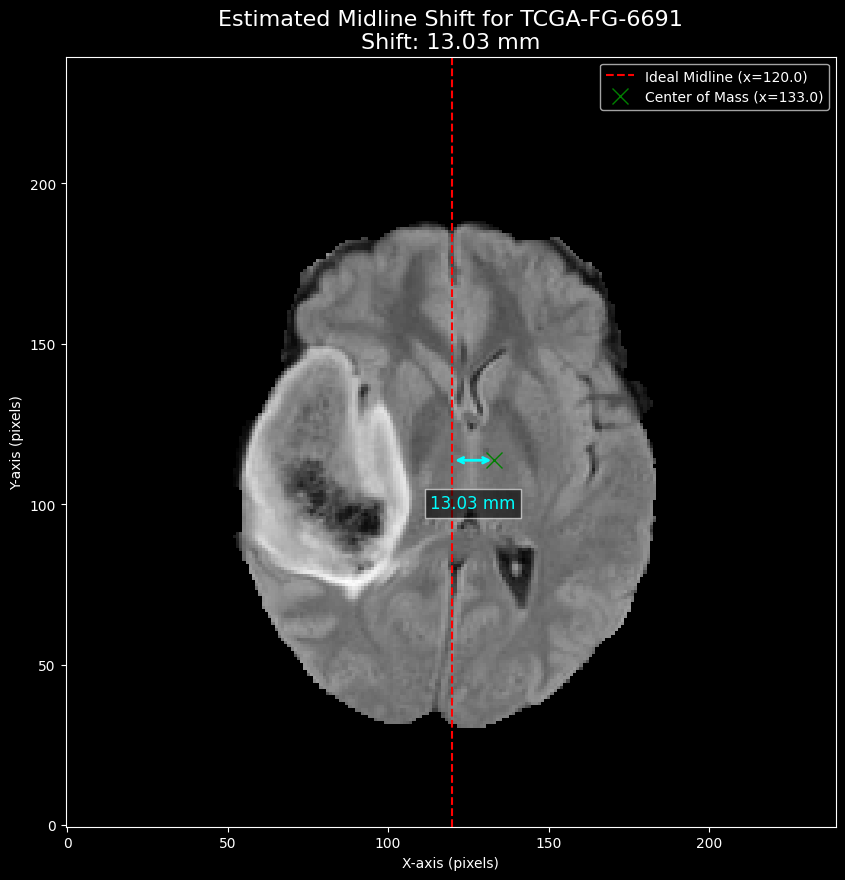

Processing patient 46/61: TCGA_FG_6692


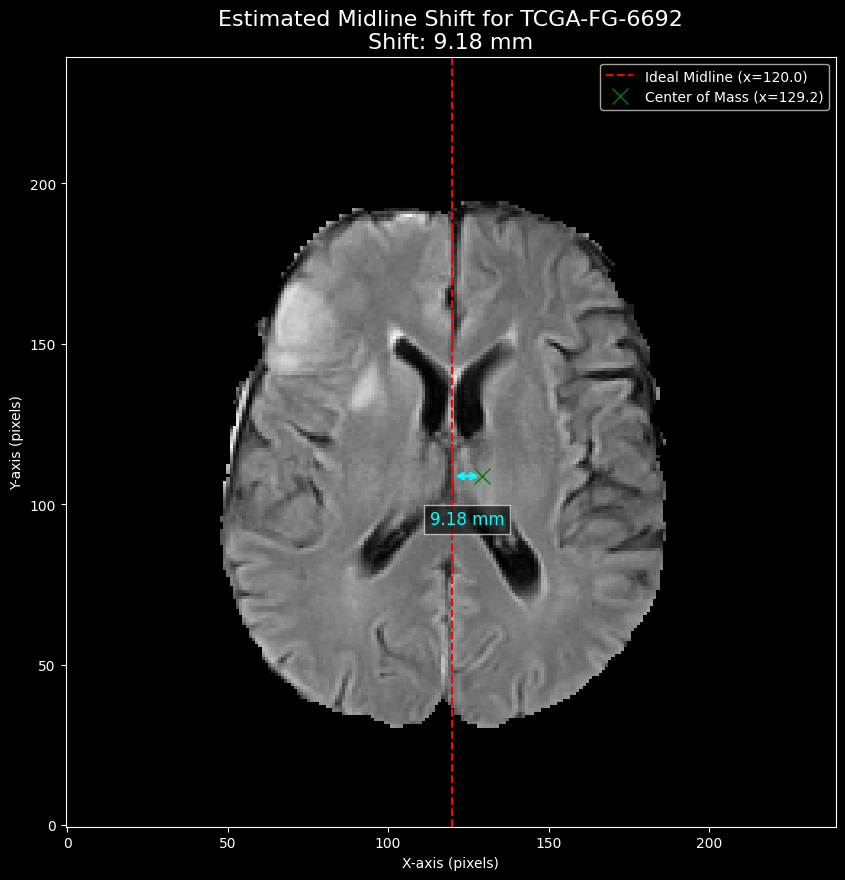

Processing patient 47/61: TCGA_FG_7634


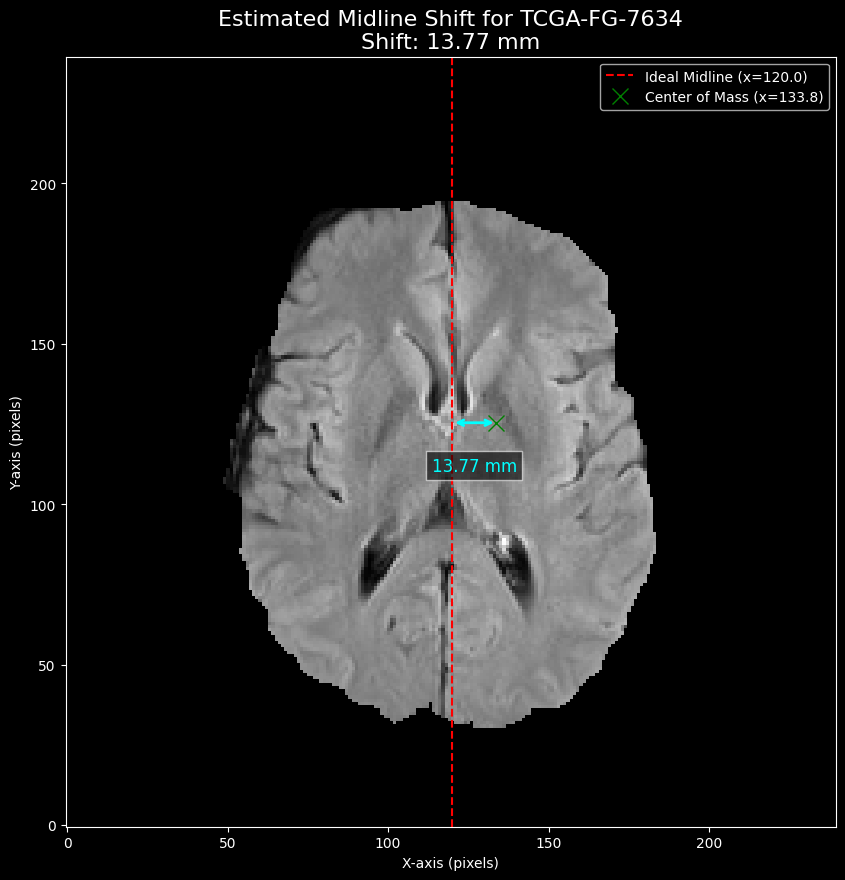

Processing patient 48/61: TCGA_FG_A4MT


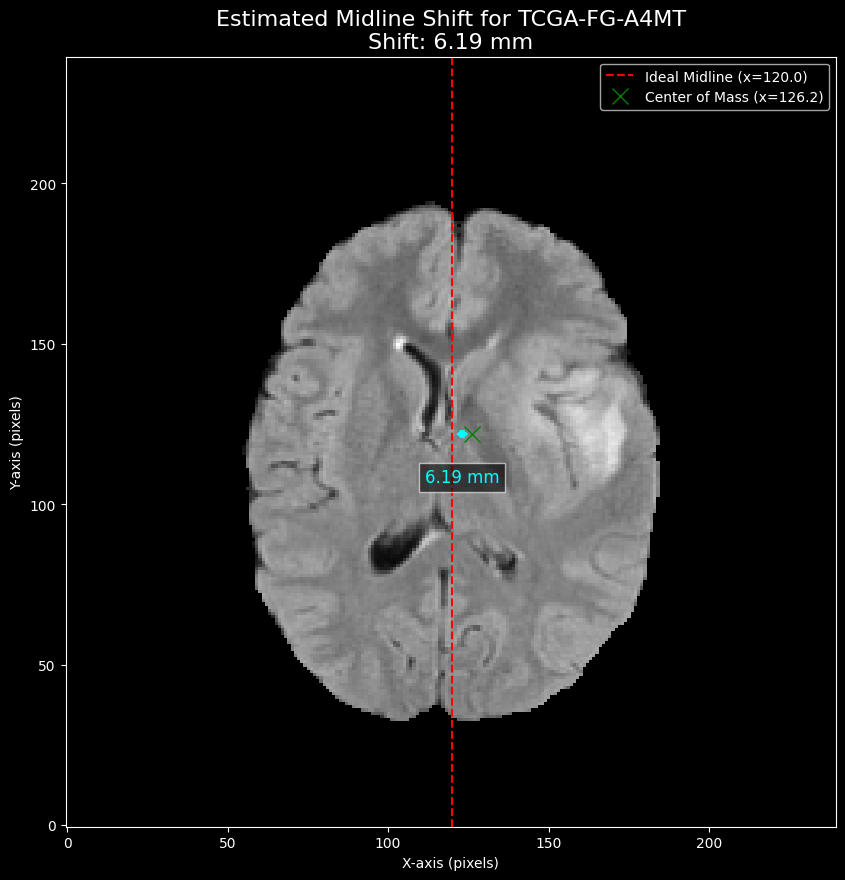

Processing patient 49/61: TCGA_HT_7473


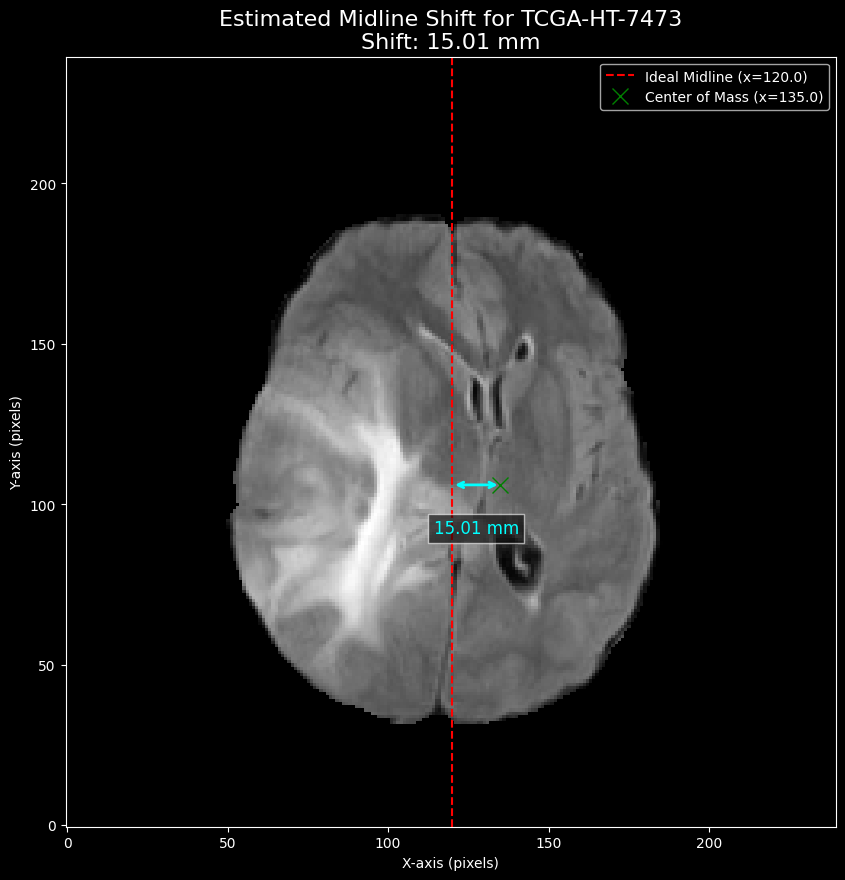

Processing patient 50/61: TCGA_HT_7602


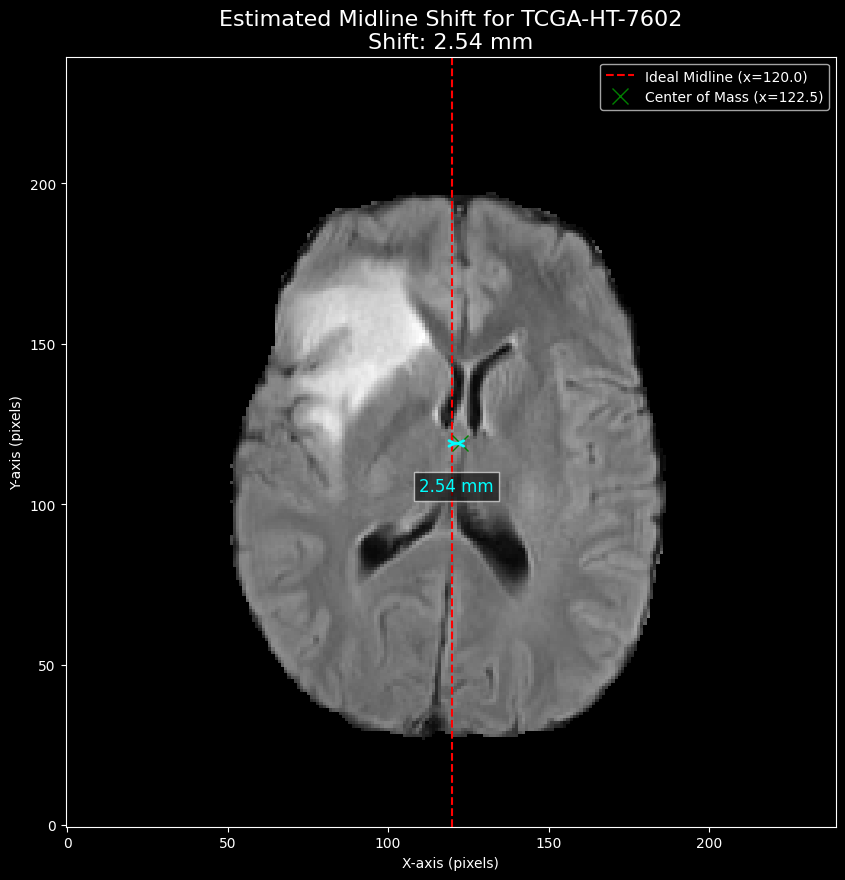

Processing patient 51/61: TCGA_HT_7680


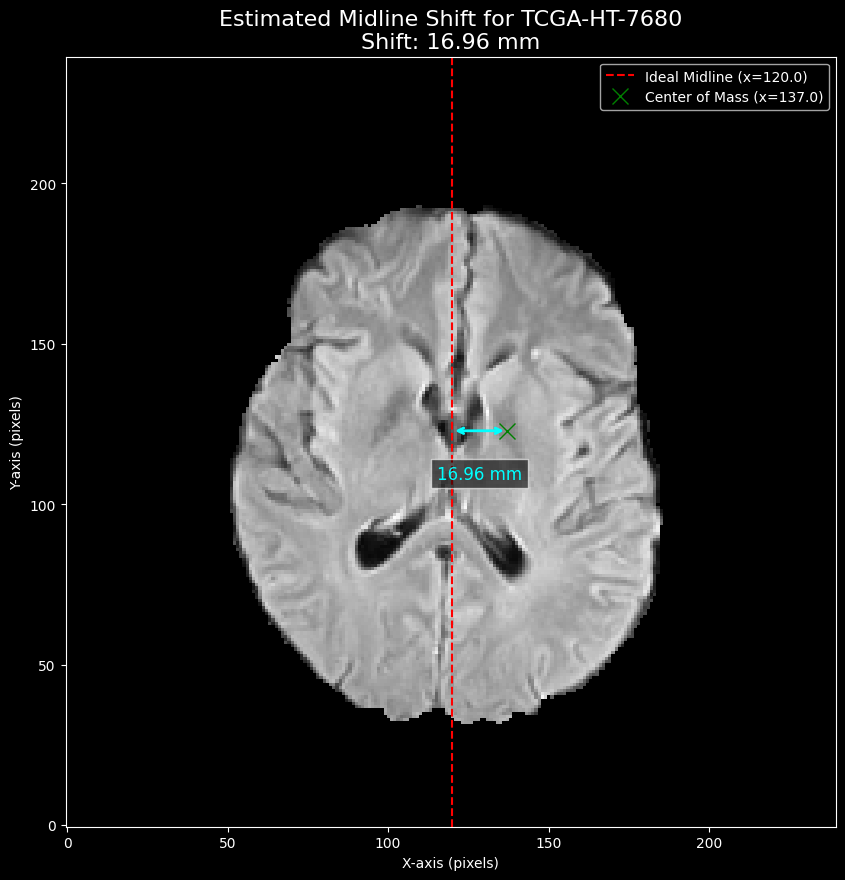

Processing patient 52/61: TCGA_HT_7686


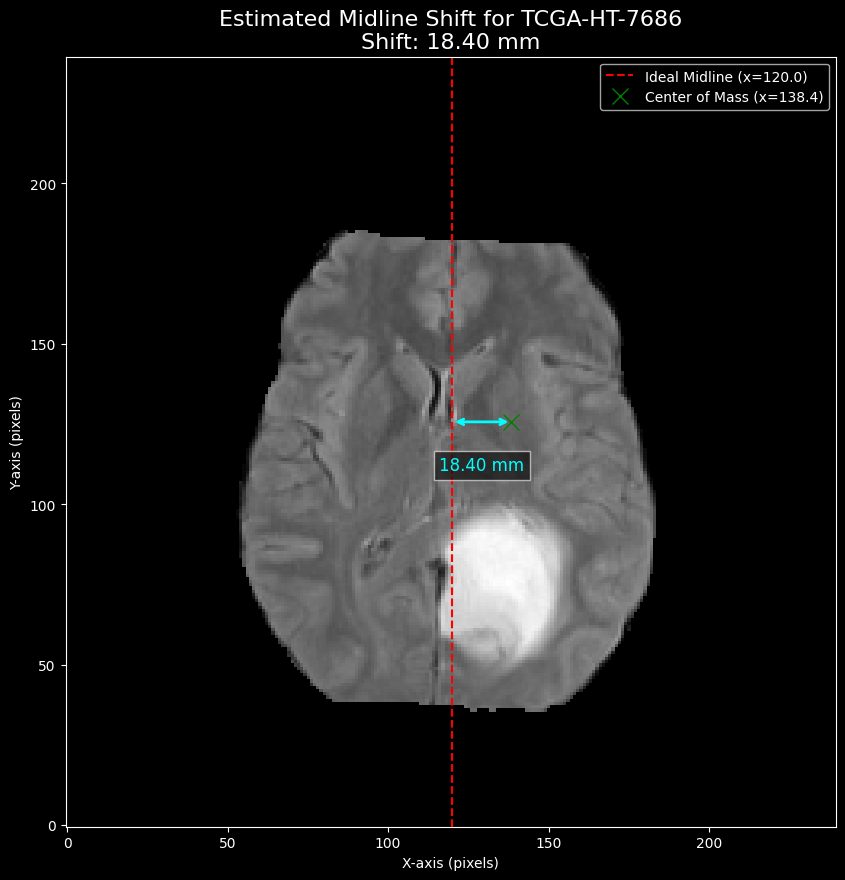

Processing patient 53/61: TCGA_HT_7690


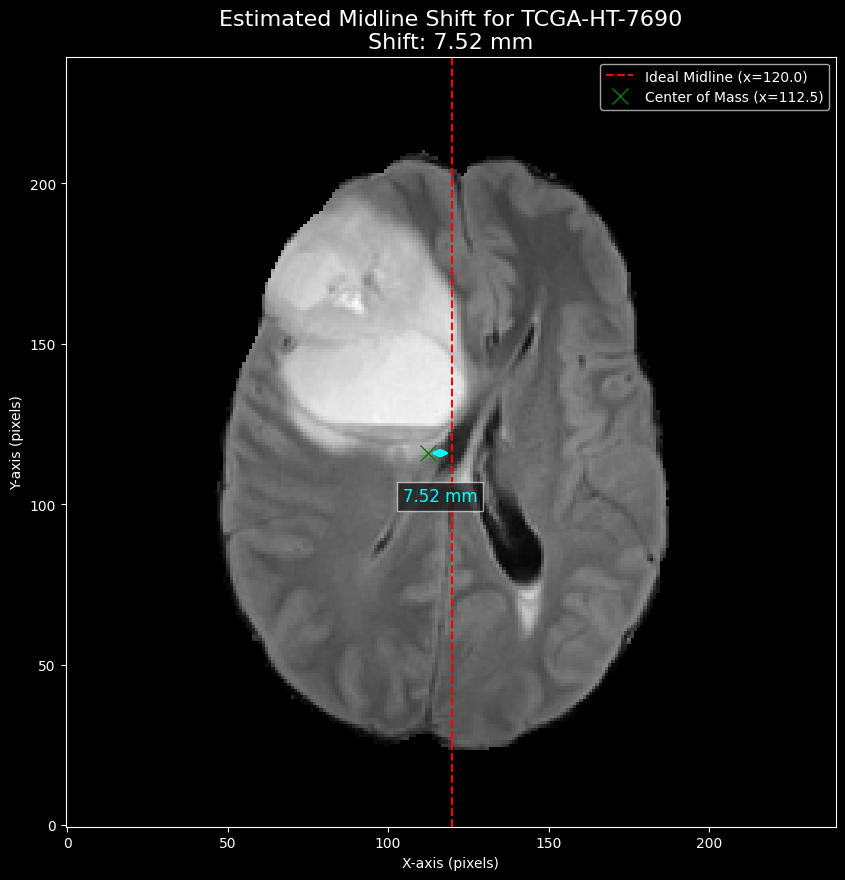

Processing patient 54/61: TCGA_HT_7694


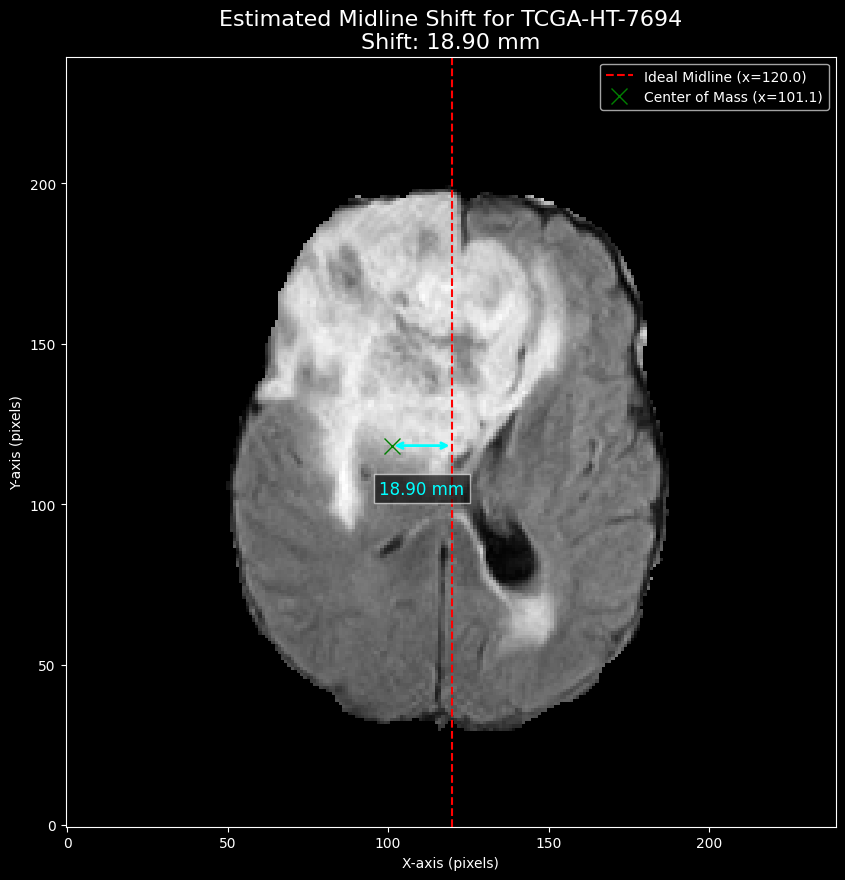

Processing patient 55/61: TCGA_HT_7879


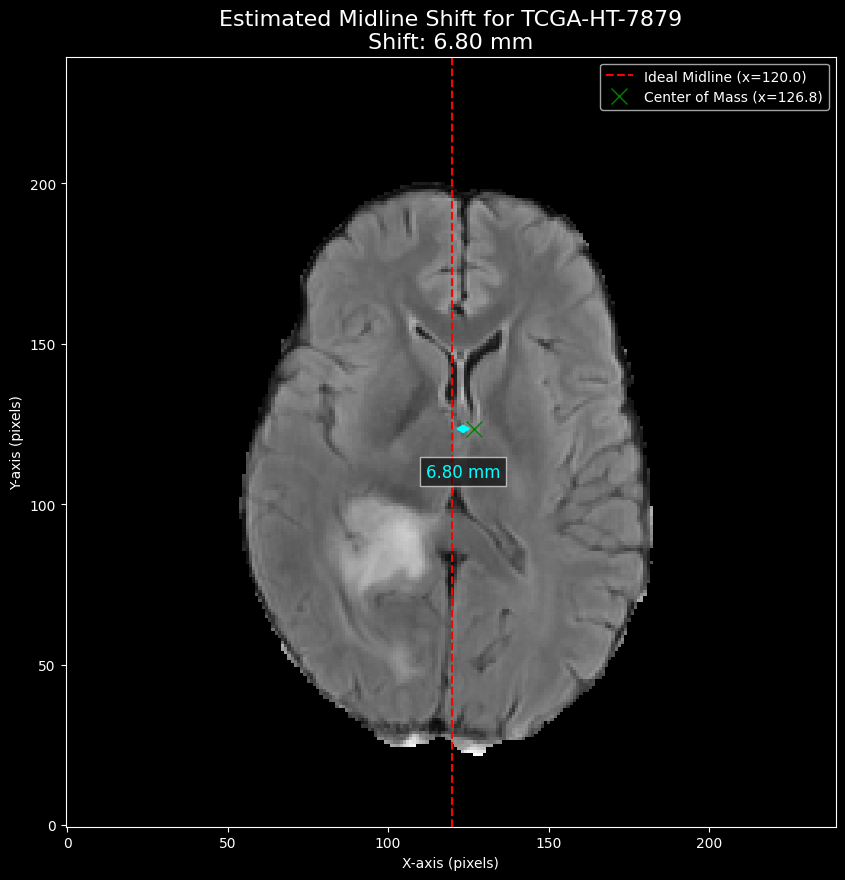

Processing patient 56/61: TCGA_HT_7884


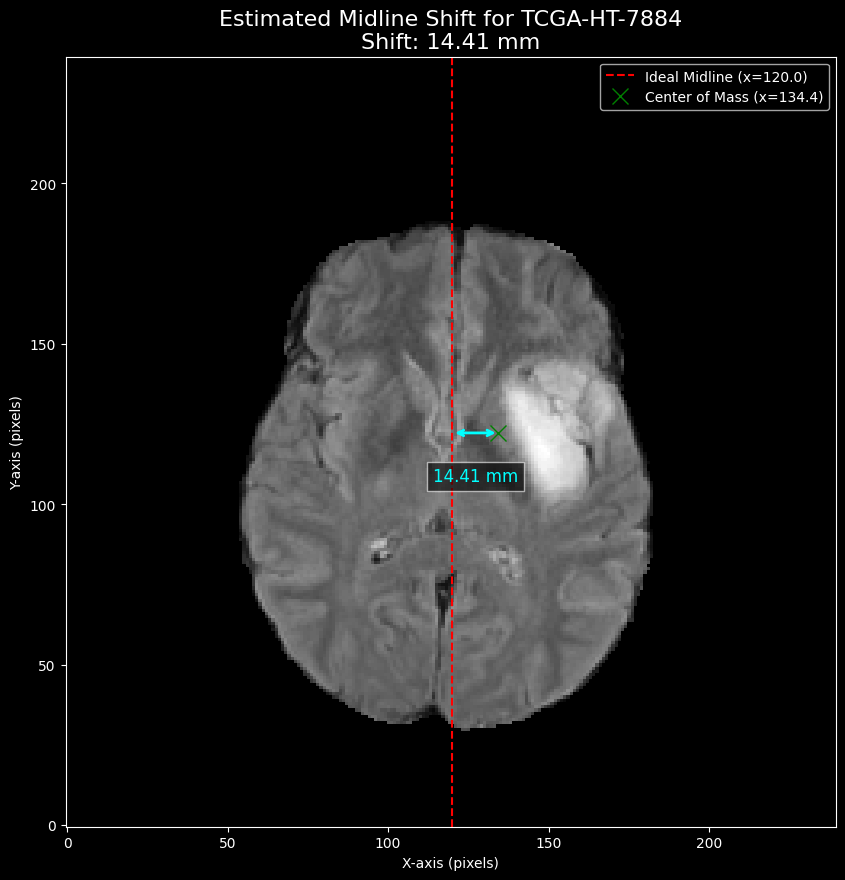

Processing patient 57/61: TCGA_HT_8018


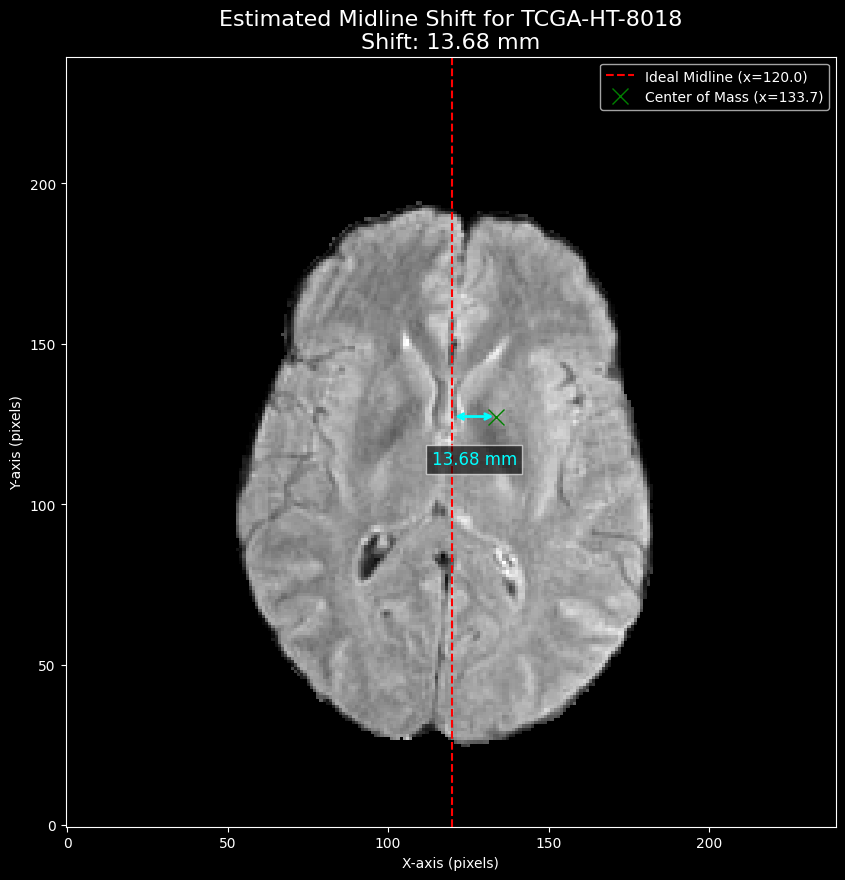

Processing patient 58/61: TCGA_HT_8111


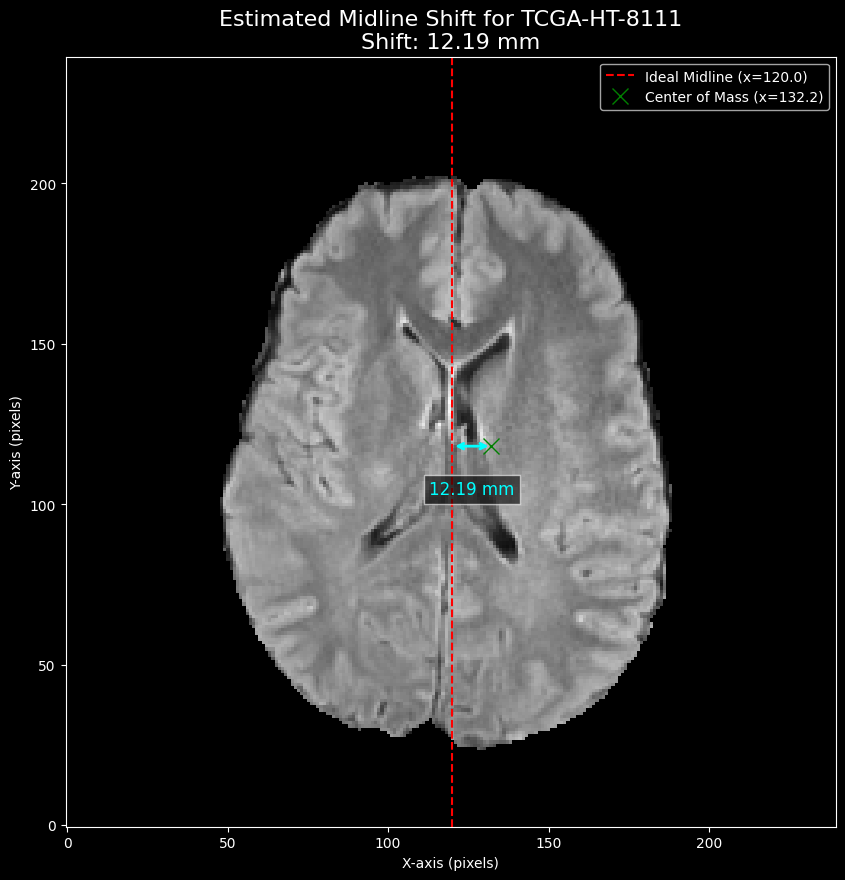

Processing patient 59/61: TCGA_HT_8114


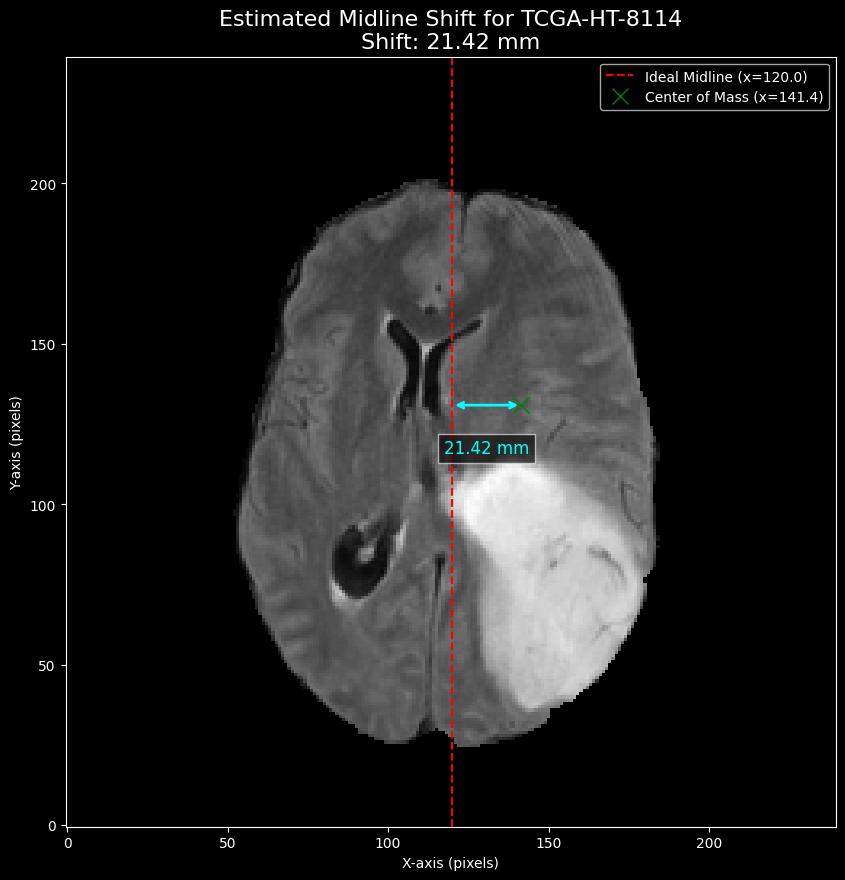

Processing patient 60/61: TCGA_HT_8563


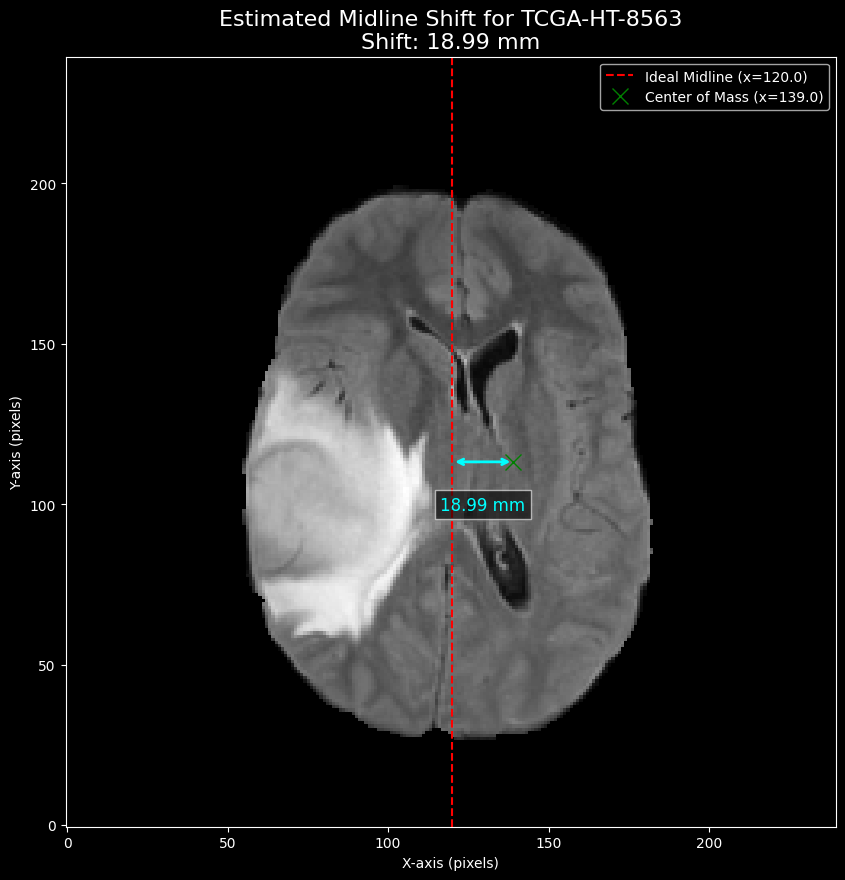

Processing patient 61/61: TCGA_HT_A61A


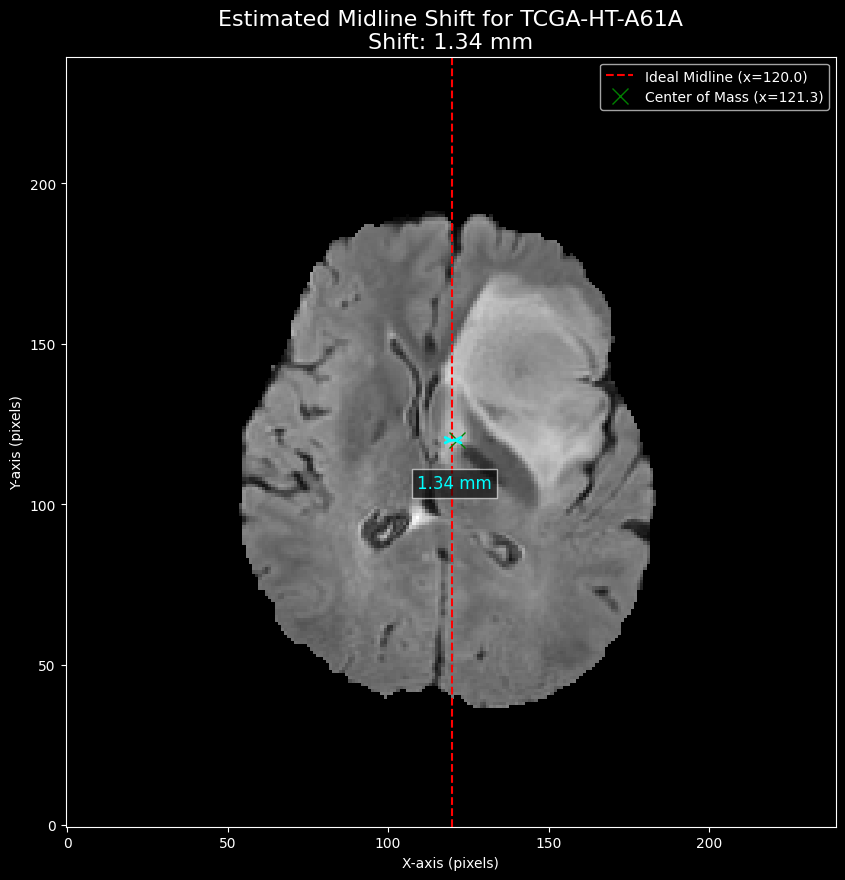


--- Estimated Midline Shift Report (Centroid Method) ---
--------------------------------------------------
Patient ID           | Estimated Shift (mm)     
--------------------------------------------------
TCGA_CS_4942         | 0.88                     
TCGA_CS_4944         | 12.49                    
TCGA_CS_5393         | 9.72                     
TCGA_CS_5396         | 12.91                    
TCGA_CS_5397         | 15.68                    
TCGA_CS_6186         | 5.52                     
TCGA_CS_6188         | 11.96                    
TCGA_CS_6665         | 11.66                    
TCGA_CS_6666         | 9.72                     
TCGA_CS_6668         | 24.03                    
TCGA_CS_6669         | 18.68                    
TCGA_DU_5851         | 4.84                     
TCGA_DU_5854         | 9.95                     
TCGA_DU_5855         | 7.75                     
TCGA_DU_5872         | 5.73                     
TCGA_DU_5874         | 5.48                     
TCGA_DU

In [ ]:
import os
import glob
import warnings
import re
from typing import List

import pandas as pd
import numpy as np
import nibabel as nib
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt


warnings.simplefilter(action='ignore', category=FutureWarning)

def compare_patient_ids(radiomics_df: pd.DataFrame, clinical_df: pd.DataFrame):

    print("--- Comparing Patient IDs Across Datasets ---")

    if 'ID' not in radiomics_df.columns or 'Patient' not in clinical_df.columns:
        print("Warning: Could not perform comparison due to missing ID columns ('ID' or 'Patient').")
        return

    radiomics_patients = set(radiomics_df['ID'])
    clinical_patients = set(clinical_df['Patient'])

    common_patients = radiomics_patients.intersection(clinical_patients)
    unique_to_radiomics = radiomics_patients.difference(clinical_patients)
    unique_to_clinical = clinical_patients.difference(radiomics_patients)

    print(f"Total patients in Radiomic Features file: {len(radiomics_patients)}")
    print(f"Total patients in Clinical Data file (kaggle_3m): {len(clinical_patients)}")
    print("-" * 25)
    print(f"Number of patients in BOTH files: {len(common_patients)}")
    print(f"Patients unique to Radiomic Features: {len(unique_to_radiomics)}")
    print(f"Patients unique to Clinical Data:   {len(unique_to_clinical)}")
    print("--- End of Comparison Report ---\n")

def get_patient_id_from_path(path: str) -> str:

    folder_or_file_name = os.path.basename(path)
    base_name = folder_or_file_name.replace('.nii.gz', '')

    match = re.match(r'(TCGA-\w{2}-\w{4})', base_name)
    if match:
        return match.group(1).replace('-', '_')
    return "_".join(base_name.split("_")[0:3])

def estimate_and_visualize_shift(nifti_path: str, patient_id: str) -> float:

    try:
        if not os.path.exists(nifti_path):
            return -1.0

        nii_image = nib.load(nifti_path)
        image_data = nii_image.get_fdata()
        voxel_dims = nii_image.header.get_zooms()
        voxel_width_mm = voxel_dims[0]

        middle_slice_index = image_data.shape[2] // 2
        selected_slice = image_data[:, :, middle_slice_index]

        threshold = np.percentile(selected_slice[selected_slice > 0], 50)
        brain_mask = selected_slice > threshold

        if not np.any(brain_mask):
             return 0.0

        com_y, com_x = center_of_mass(brain_mask)
        geometric_midline_x = selected_slice.shape[1] / 2.0
        shift_in_pixels = abs(com_x - geometric_midline_x)
        shift_in_mm = shift_in_pixels * voxel_width_mm


        plt.style.use('dark_background')
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(np.rot90(selected_slice), cmap='gray')
        ax.axvline(geometric_midline_x, color='red', linestyle='--', label=f'Ideal Midline (x={geometric_midline_x:.1f})')
        ax.plot(com_x, com_y, 'gx', markersize=12, label=f'Center of Mass (x={com_x:.1f})')

        ax.annotate(
            '', xy=(geometric_midline_x, com_y), xytext=(com_x, com_y),
            arrowprops=dict(arrowstyle='<->', color='cyan', lw=2)
        )
        ax.text(
            (geometric_midline_x + com_x) / 2, com_y - 15,
            f'{shift_in_mm:.2f} mm', color='cyan', ha='center', fontsize=12,
            bbox=dict(facecolor='black', alpha=0.6)
        )

        ax.set_title(f"Estimated Midline Shift for {patient_id.replace('_', '-')}\nShift: {shift_in_mm:.2f} mm", fontsize=16)
        ax.set_xlabel("X-axis (pixels)")
        ax.set_ylabel("Y-axis (pixels)")
        ax.legend()
        ax.grid(False)
        ax.invert_yaxis()

        plt.show()

        return shift_in_mm

    except Exception:

        return -1.0

if __name__ == "__main__":

    BASE_PATH_KAGGLE = "/home/ealam/Downloads/LGG dataset Cameron/lgg-mri-segmentation/kaggle_3m"
    BASE_PATH_TCGA = "/home/ealam/Downloads/Pre-operative_TCGA_LGG_NIfTI_and_Segmentations"
    CLINICAL_CSV_PATH = os.path.join(BASE_PATH_KAGGLE, "data.csv")
    RADIOMICS_CSV_PATH = os.path.join(BASE_PATH_TCGA, "TCGA_LGG_radiomicFeatures.csv")

    if not all(os.path.exists(p) for p in [BASE_PATH_KAGGLE, BASE_PATH_TCGA, CLINICAL_CSV_PATH, RADIOMICS_CSV_PATH]):
        print("Error")
    else:

        clinical_df = pd.read_csv(CLINICAL_CSV_PATH)
        radiomics_df = pd.read_csv(RADIOMICS_CSV_PATH)
        radiomics_df['ID'] = radiomics_df['ID'].str.replace('-', '_')


        compare_patient_ids(radiomics_df, clinical_df)


        radiomics_patients = set(radiomics_df['ID'])
        clinical_patients = set(clinical_df['Patient'])
        common_patients = sorted(list(radiomics_patients.intersection(clinical_patients)))

        print(f"Found {len(common_patients)} patients common to both datasets.")



        shift_results = {}
        for i, patient_id in enumerate(common_patients):
            print(f"Processing patient {i+1}/{len(common_patients)}: {patient_id}")
            patient_folder_name = patient_id.replace('_', '-')
            nifti_file_pattern = os.path.join(BASE_PATH_TCGA, patient_folder_name, f"*{patient_folder_name}*flair.nii.gz")

            found_files = glob.glob(nifti_file_pattern)
            if found_files:
                estimated_shift = estimate_and_visualize_shift(found_files[0], patient_id)
                shift_results[patient_id] = estimated_shift
            else:
                shift_results[patient_id] = -1.0


        print("\n--- Estimated Midline Shift Report (Centroid Method) ---")
        print("-" * 50)
        print(f"{'Patient ID':<20} | {'Estimated Shift (mm)':<25}")
        print("-" * 50)
        for patient_id, shift in shift_results.items():
            if shift < 0:
                report_str = "Error / File Not Found"
            else:
                report_str = f"{shift:.2f}"
            print(f"{patient_id:<20} | {report_str:<25}")
        print("-" * 50)



